# 1. 라이브러리 및 데이터

In [2]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import random
import warnings
warnings.filterwarnings('ignore')
import time
import re
from scipy.stats import kstest

from sklearn.mixture import GaussianMixture

In [3]:
# 시드고정 

DEFAULT_RANDOM_SEED = 2021

def seedBasic(seed=DEFAULT_RANDOM_SEED):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

In [4]:
train = pd.read_csv('train.csv')
test = pd.read_csv("test.csv")
sub = pd.read_csv("sample_submission.csv")

# 2. EDA

### 데이터 정보

In [4]:
main = train.iloc[:,1:2]
numeric = train.iloc[:,2:]

In [5]:
# 수치형임을 확인, 설명변수 200개 -> 변수 선택 및 차원 축소 고려
train.head(3)

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_1,0,15.4140,-2.1016,10.4773,4.8941,12.6506,-3.7205,5.1426,17.7048,...,-2.8810,8.1647,1.0927,2.1215,17.6536,3.2253,-2.1234,8.9516,13.3485,-16.0178
1,train_2,0,12.3576,-8.1666,11.7785,2.8869,12.3183,-6.9847,4.2671,9.6710,...,0.2397,8.1569,-1.0753,5.4679,23.6376,-0.5022,9.2414,8.2427,10.7546,-3.4394
2,train_3,0,9.4142,-8.6132,7.2196,3.2496,10.6550,-3.3245,5.1010,18.5389,...,8.1638,9.2399,1.0160,7.4548,17.0933,0.0715,-4.0455,9.4586,17.8789,-13.9784


In [6]:
train.info

<bound method DataFrame.info of              ID_code  target    var_0   var_1    var_2    var_3    var_4  \
0            train_1       0  15.4140 -2.1016  10.4773   4.8941  12.6506   
1            train_2       0  12.3576 -8.1666  11.7785   2.8869  12.3183   
2            train_3       0   9.4142 -8.6132   7.2196   3.2496  10.6550   
3            train_4       0  13.0647 -0.7917  13.0270   8.7865  10.2252   
4            train_5       0   9.5222 -0.2727   8.2173   8.4071  12.7732   
...              ...     ...      ...     ...      ...      ...      ...   
159995  train_159996       0   8.0801 -2.5523  10.6587  10.6660   8.7552   
159996  train_159997       0  11.8371 -4.9598  12.9172   9.3759  13.0622   
159997  train_159998       0  11.3368  1.2790  14.1568  11.9850  11.4859   
159998  train_159999       0   3.4660 -0.2570   4.3530   7.2045  11.4988   
159999  train_160000       0   8.5913 -0.8183  11.0295   5.9502  12.9875   

          var_5   var_6    var_7  ...  var_190  var_191

In [7]:
train.describe()

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,160000.000000,160000.000000,160000.000000,160000.000000,160000.000000,160000.000000,160000.000000,160000.000000,160000.000000,160000.000000,...,160000.000000,160000.000000,160000.000000,160000.000000,160000.000000,160000.000000,160000.000000,160000.000000,160000.000000,160000.000000
mean,0.100487,10.686423,-1.635005,10.717822,6.798371,11.078359,-5.063101,5.411429,16.546195,0.278720,...,3.231118,7.437430,1.926908,3.331891,17.981283,-0.137477,2.301247,8.908436,15.870663,-3.322579
std,0.300650,3.039724,4.048365,2.646578,2.041822,1.623850,7.878059,0.867974,3.418934,3.332611,...,4.563838,3.024263,1.476769,3.993505,3.133260,1.430700,5.450803,0.921079,3.013206,10.430896
min,0.000000,0.408400,-15.043400,2.117100,-0.040200,5.074800,-32.562600,2.347300,5.749400,-10.505500,...,-14.093300,-2.691700,-3.814500,-11.783400,8.694400,-5.261000,-14.209600,5.960600,6.299300,-38.852800
25%,0.000000,8.460400,-4.747125,8.722075,5.258000,9.880675,-11.218200,4.769400,13.947575,-2.323225,...,-0.069275,5.157400,0.891100,0.580475,15.620400,-1.165900,-1.942200,8.254300,13.828400,-11.187300
50%,0.000000,10.529800,-1.623700,10.581400,6.829450,11.109900,-4.826700,5.387400,16.460200,0.386900,...,3.197700,7.348050,1.900850,3.397150,17.944900,-0.168900,2.414100,8.888700,15.932150,-2.825700
75%,0.000000,12.764525,1.349175,12.521625,8.321900,12.261800,0.940175,6.006400,19.102825,2.933650,...,6.411450,9.512525,2.945000,6.209025,20.378600,0.833900,6.552475,9.593500,18.063050,4.821300
max,1.000000,20.315000,10.376800,19.353000,13.188300,16.671400,17.251600,8.447700,27.691800,10.151300,...,18.342300,16.716500,8.402400,17.908600,27.928800,4.272900,17.684100,12.000400,26.079100,28.500700


## NA 확인

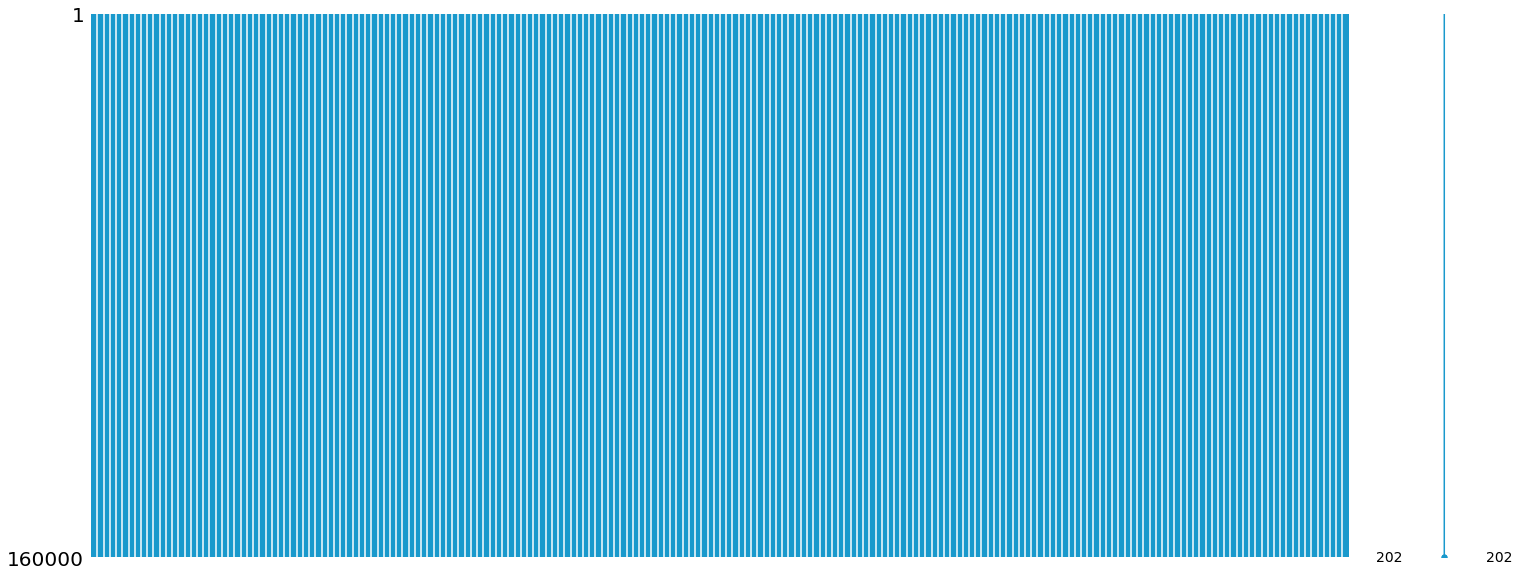

In [ ]:
msno.matrix(df=train.iloc[:, :], color=(0.1, 0.6, 0.8))

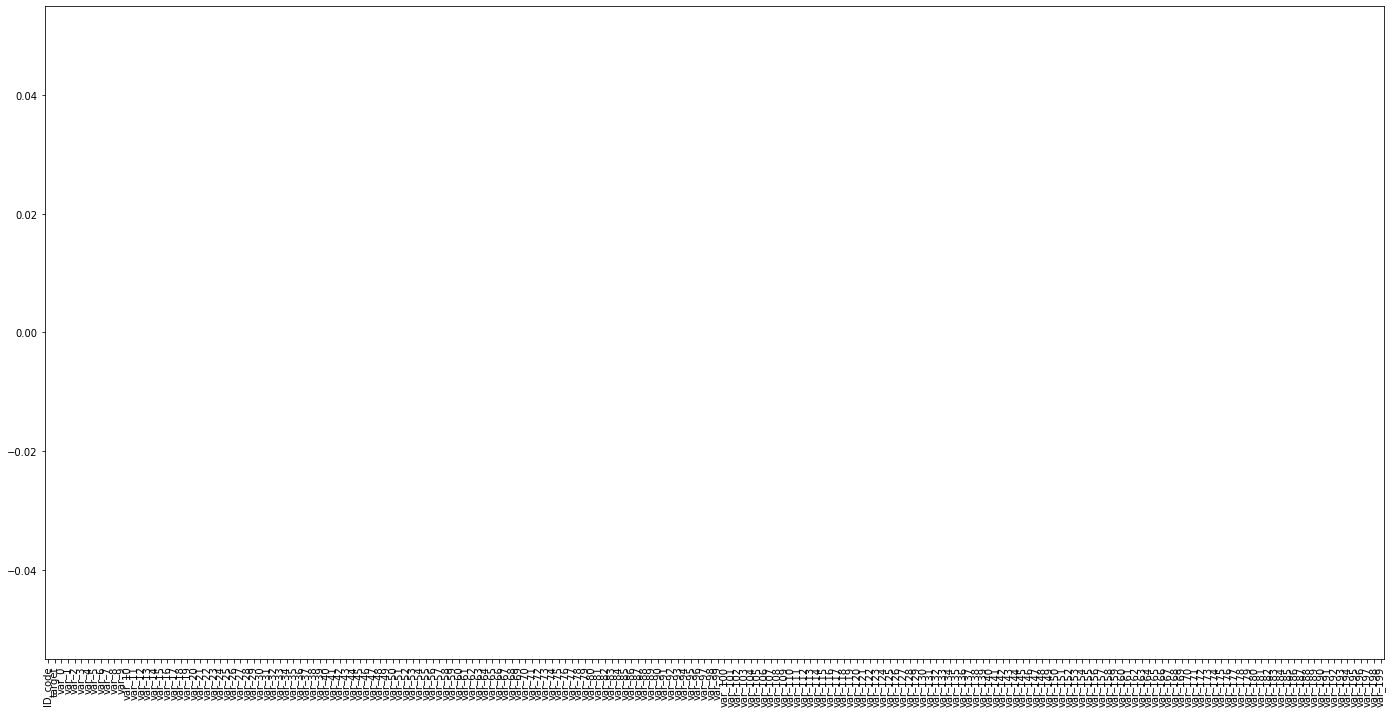

In [ ]:
train.isna().sum().plot.bar(figsize = (24,12),color=(0.1, 0.6, 0.8))

In [ ]:
train.isnull().sum()

ID_code    0
target     0
var_0      0
var_1      0
var_2      0
          ..
var_195    0
var_196    0
var_197    0
var_198    0
var_199    0
Length: 202, dtype: int64

### 중복값 확인

In [ ]:
train.duplicated().value_counts() #중복값 없음

False    160000
dtype: int64

### 클래스 불균형

In [ ]:
train['target'].value_counts()

0    143922
1     16078
Name: target, dtype: int64

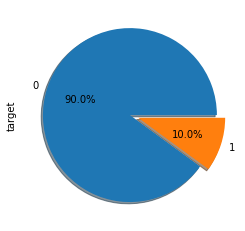

In [ ]:
train['target'].value_counts().plot.pie( 
    explode=[0,0.1],autopct='%1.1f%%',shadow=True)

### 데이터 비율 시각화

In [9]:
def plot_feature_distribution(df1, df2, label1, label2, features):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(10,10,figsize=(18,22))

    for feature in features:
        i += 1
        plt.subplot(10,10,i)
        sns.distplot(df1[feature], hist=False,label=label1)
        sns.distplot(df2[feature], hist=False,label=label2)
        plt.xlabel(feature, fontsize=9)
        locs, labels = plt.xticks()
        plt.tick_params(axis='x', which='major', labelsize=6, pad=-6)
        plt.tick_params(axis='y', which='major', labelsize=6)
    plt.show()

<Figure size 432x288 with 0 Axes>

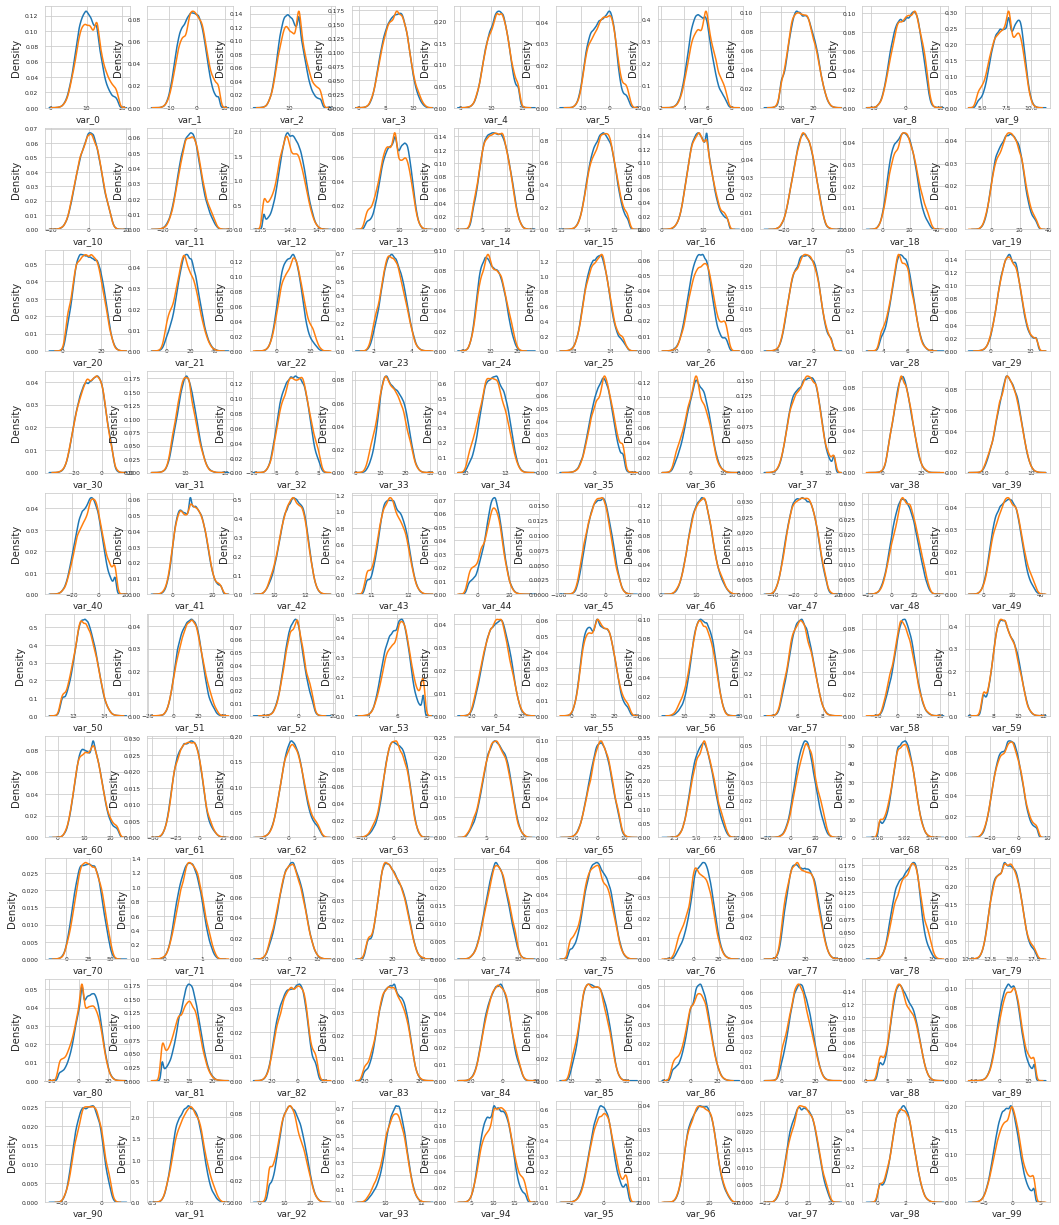

In [34]:
t0 = train.loc[train['target'] == 0]
t1 = train.loc[train['target'] == 1]
features = train.columns.values[2:102]
plot_feature_distribution(t0, t1, '0', '1', features)

<Figure size 432x288 with 0 Axes>

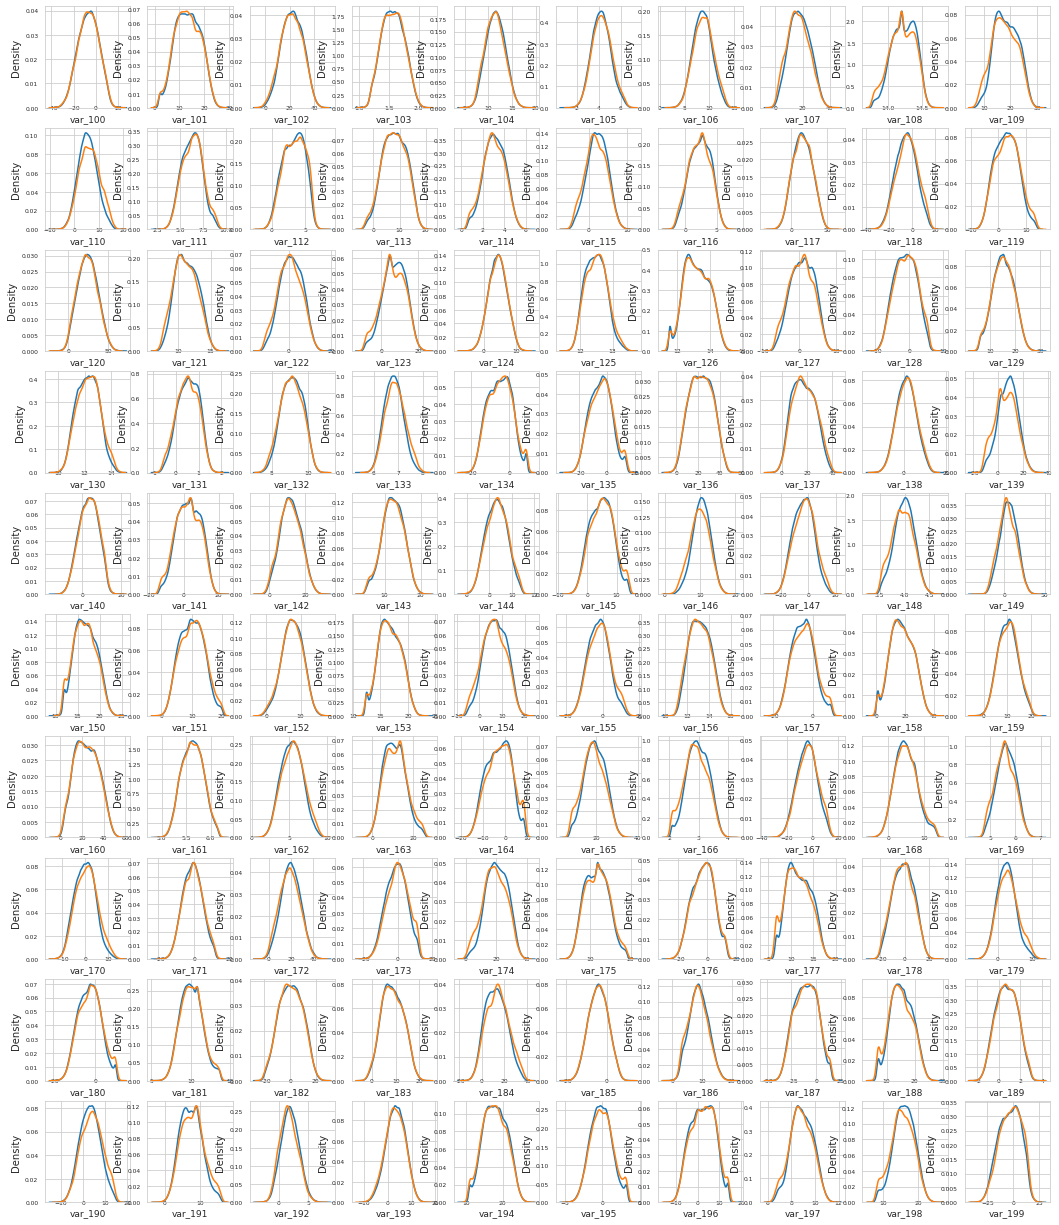

In [35]:
features = train.columns.values[102:202]
plot_feature_distribution(t0, t1, '0', '1', features)

In [ ]:
%time
train['target'].value_counts().plot.pie(
    explode = [0,0.05],autopct = '%1.1f%%', shadow =True)

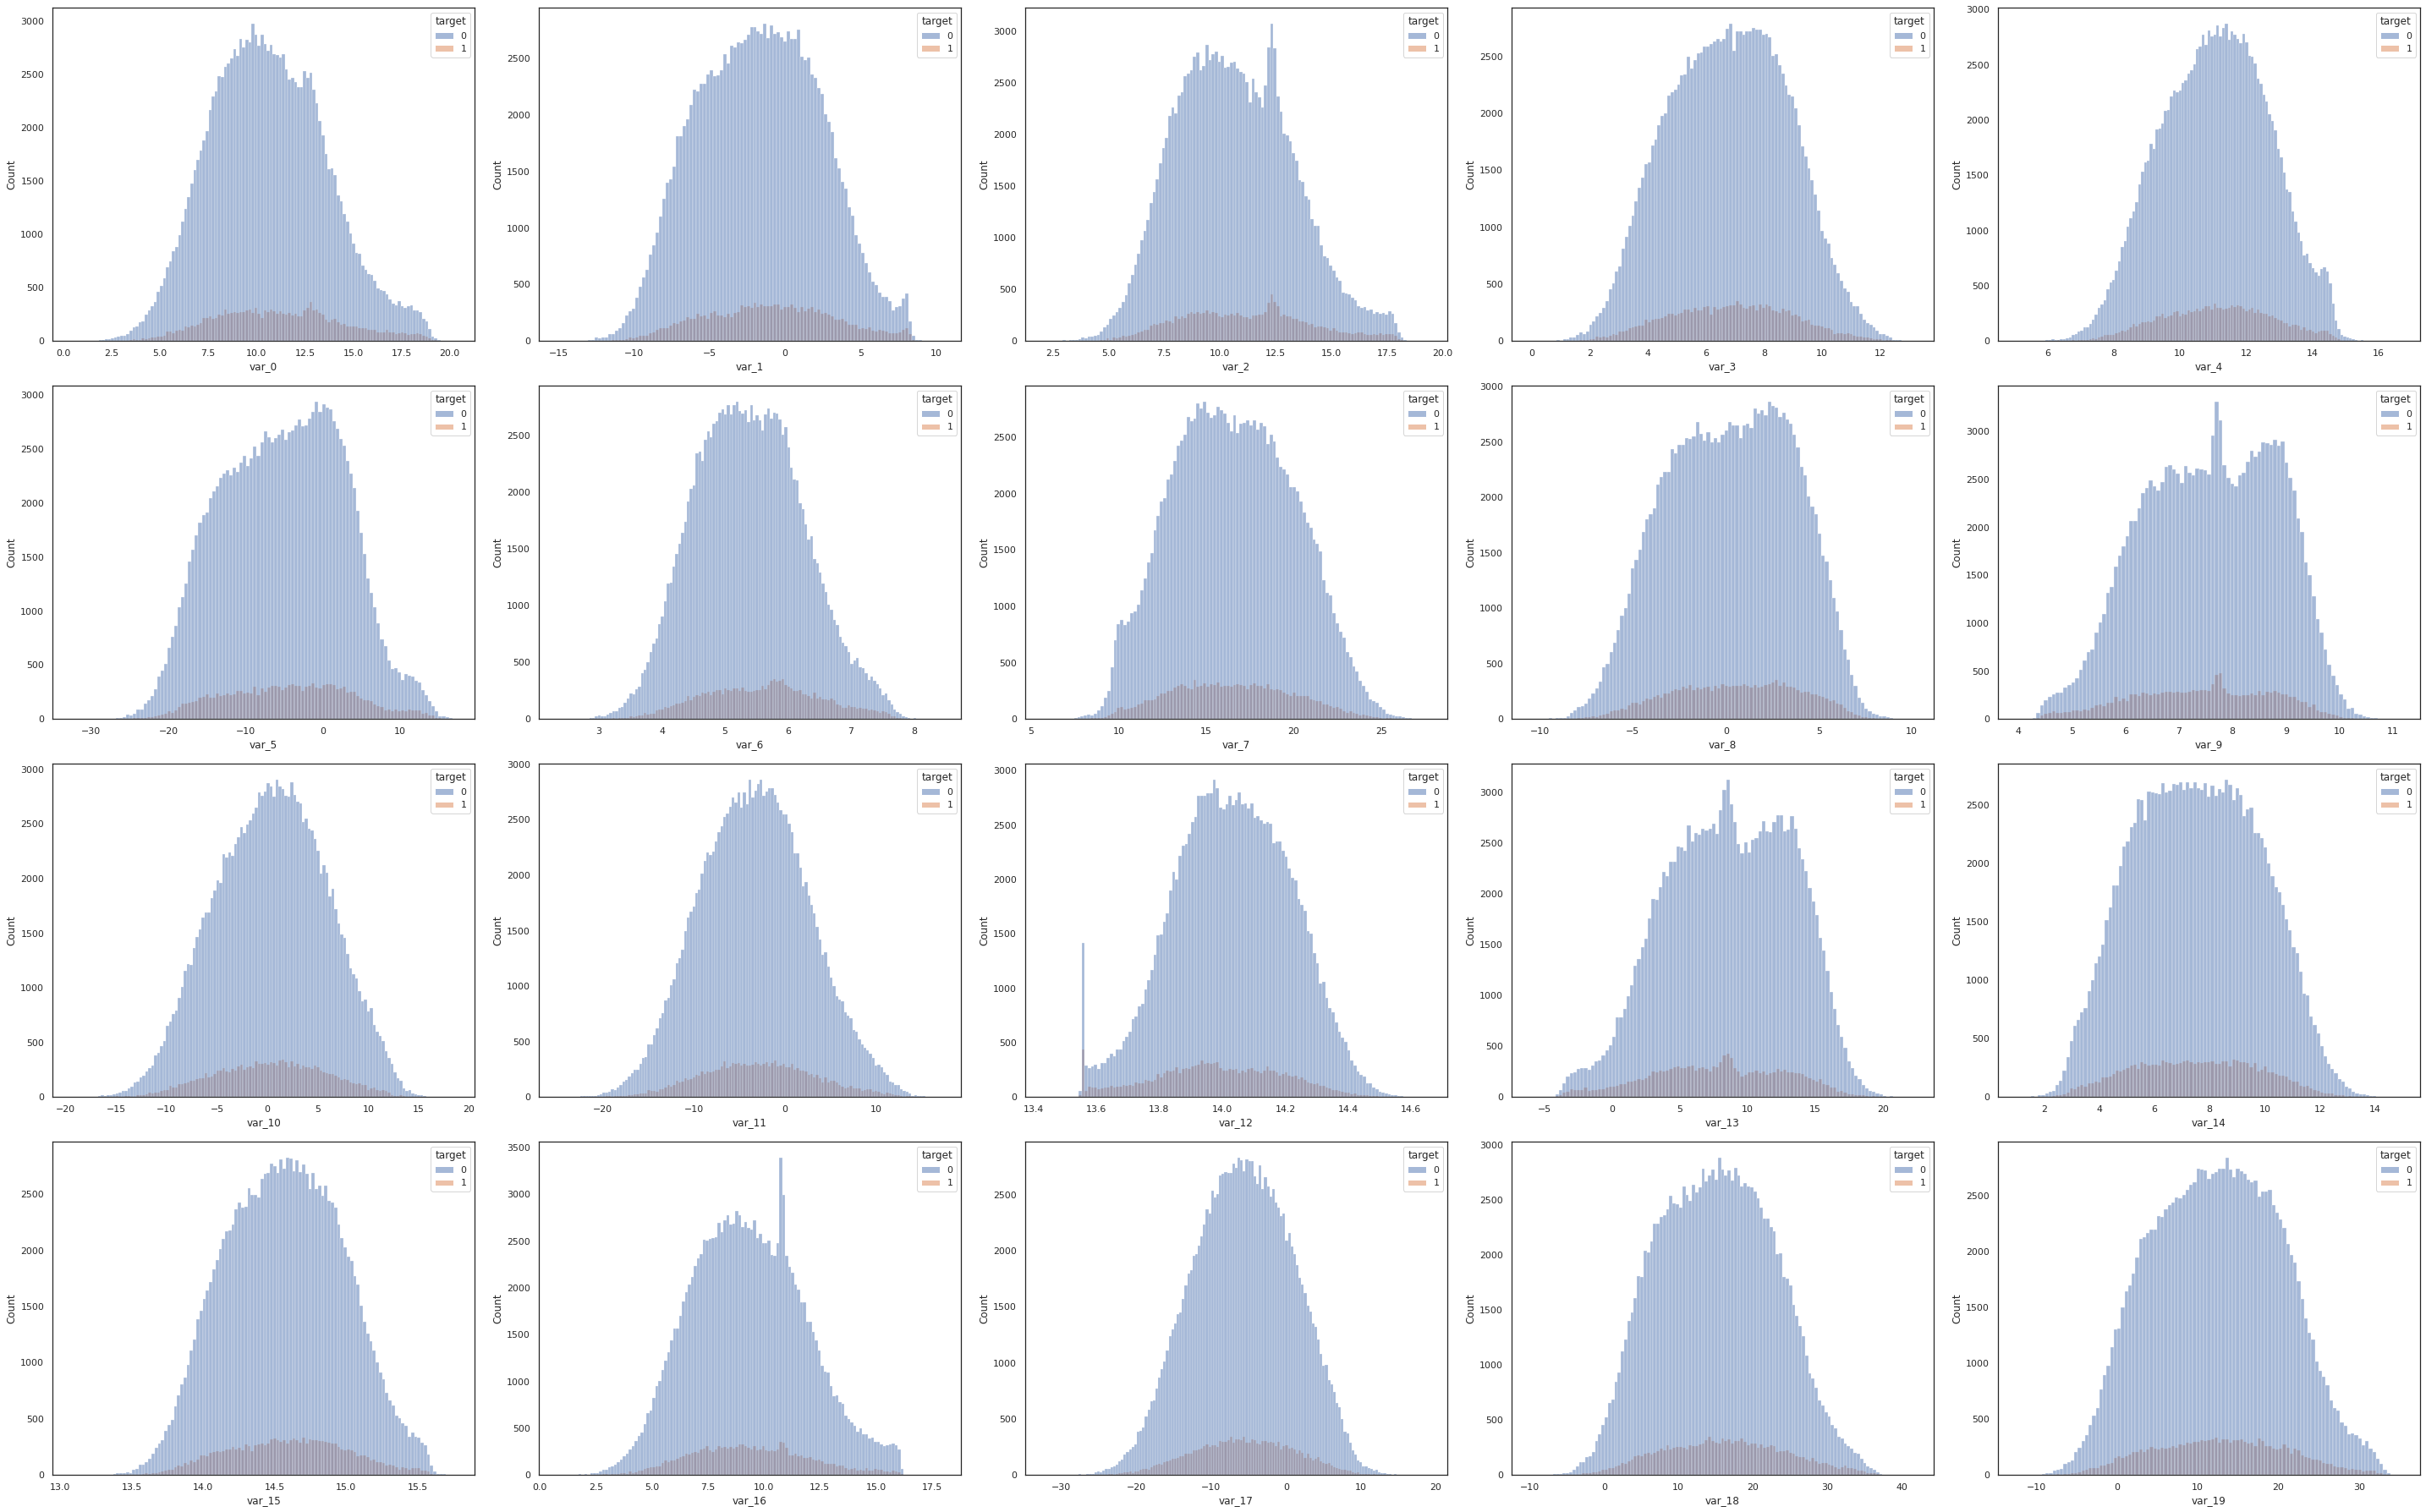

In [ ]:
plt.subplots(figsize=(40, 25))
sns.set(font_scale = 1, style = 'white')

for i, column in enumerate(train.iloc[:,2:22], 1):
    plt.subplot(4,5,i)
    sns.histplot(data=train, x=train[column], hue="target")
    
plt.tight_layout()

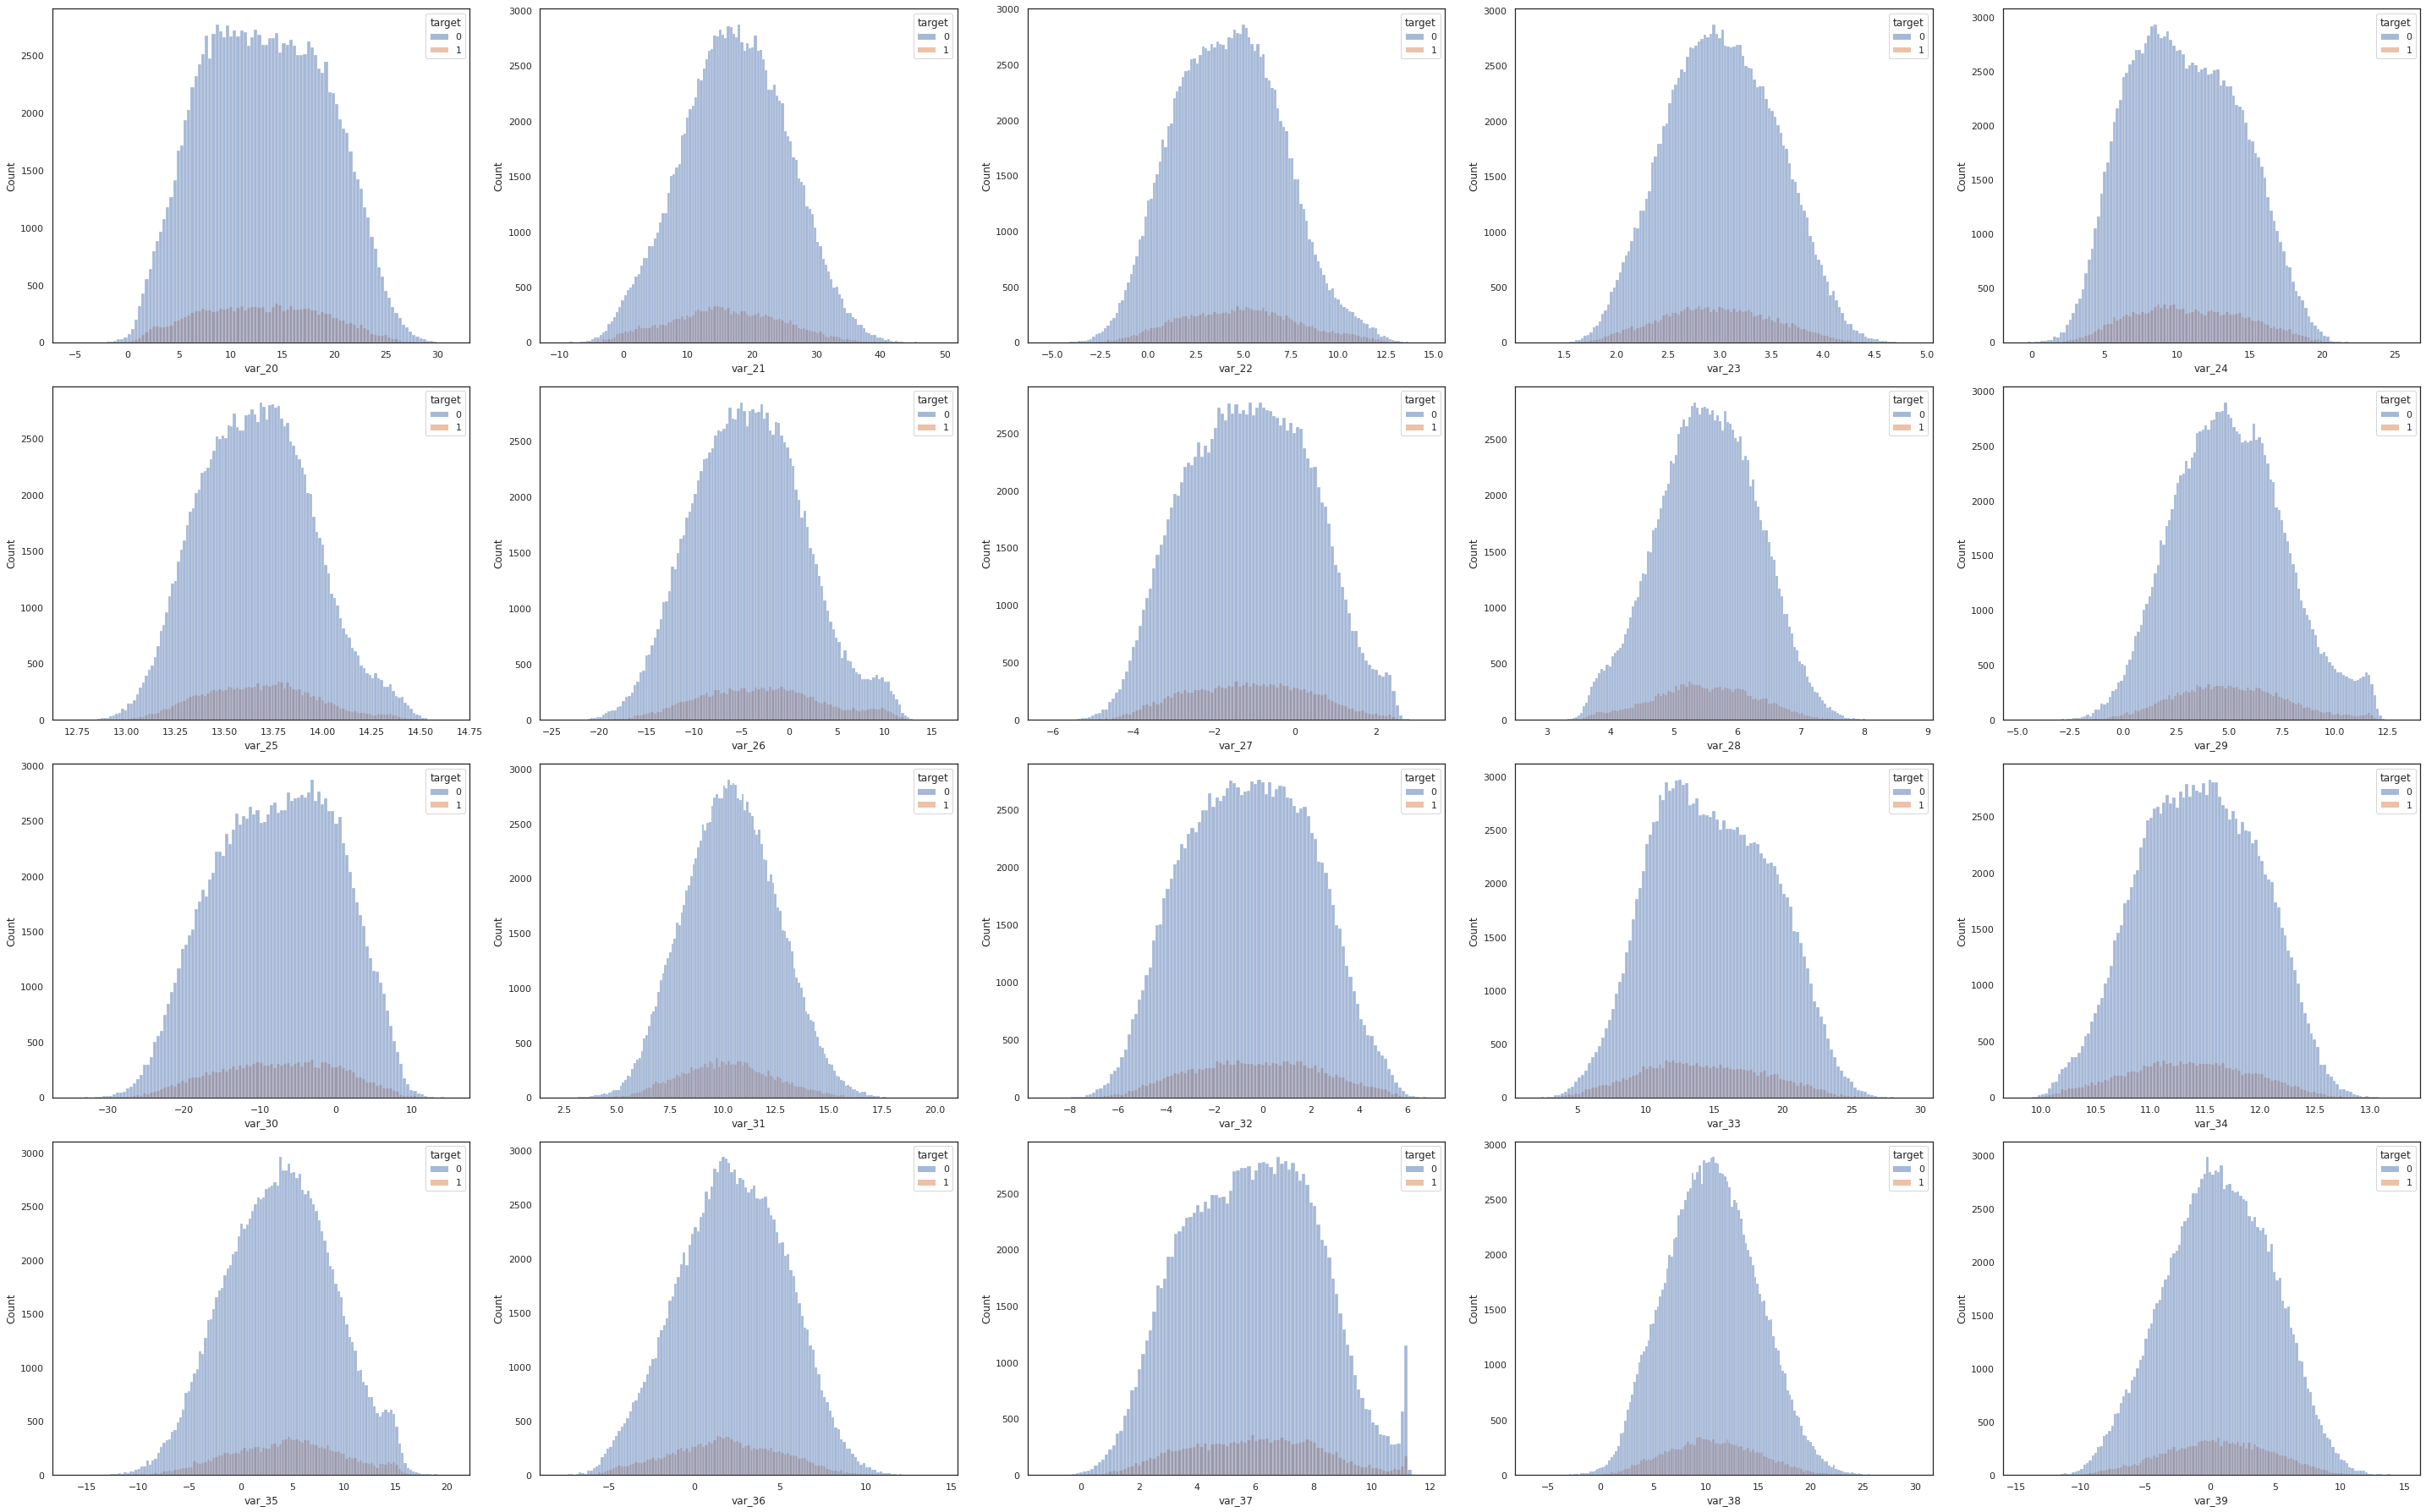

In [ ]:
plt.subplots(figsize=(40, 25))
sns.set(font_scale = 1, style = 'white')

for i, column in enumerate(train.iloc[:,22:42], 1):
    plt.subplot(4,5,i)
    sns.histplot(data=train, x=train[column], hue="target")
    
plt.tight_layout()

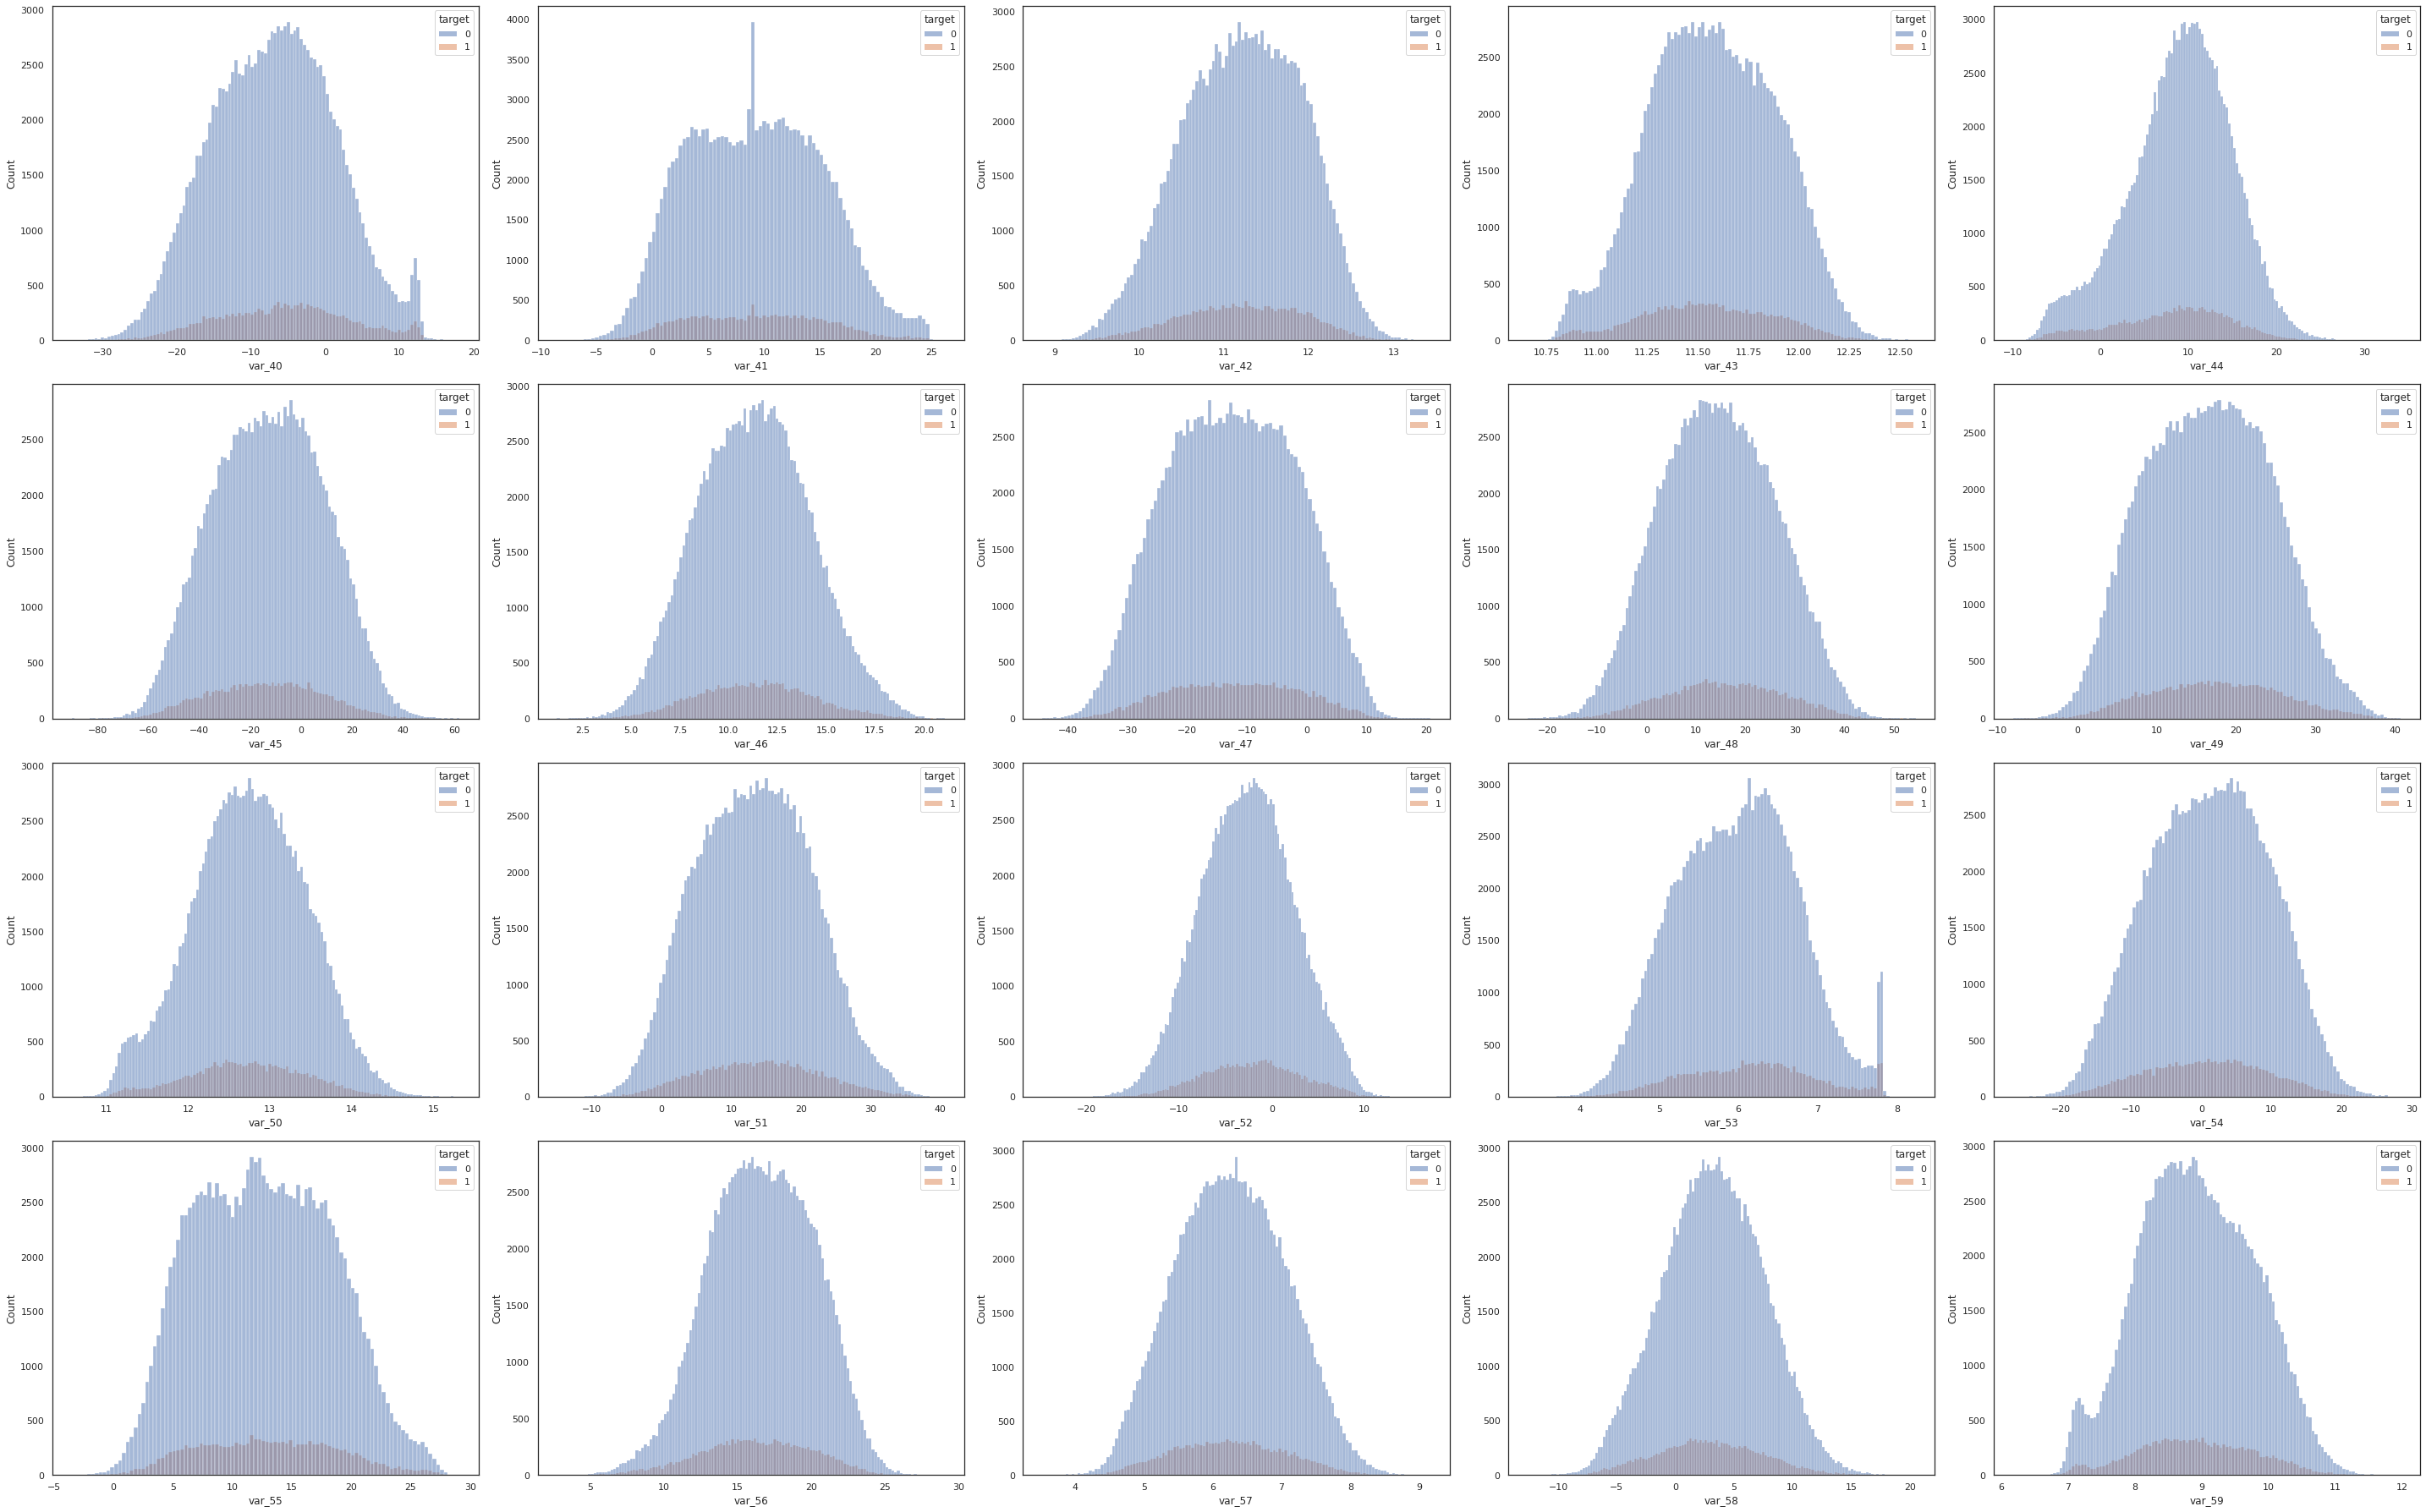

In [ ]:
plt.subplots(figsize=(40, 25))
sns.set(font_scale = 1, style = 'white')

for i, column in enumerate(train.iloc[:,42:62], 1):
    plt.subplot(4,5,i)
    sns.histplot(data=train, x=train[column], hue="target")
    
plt.tight_layout()

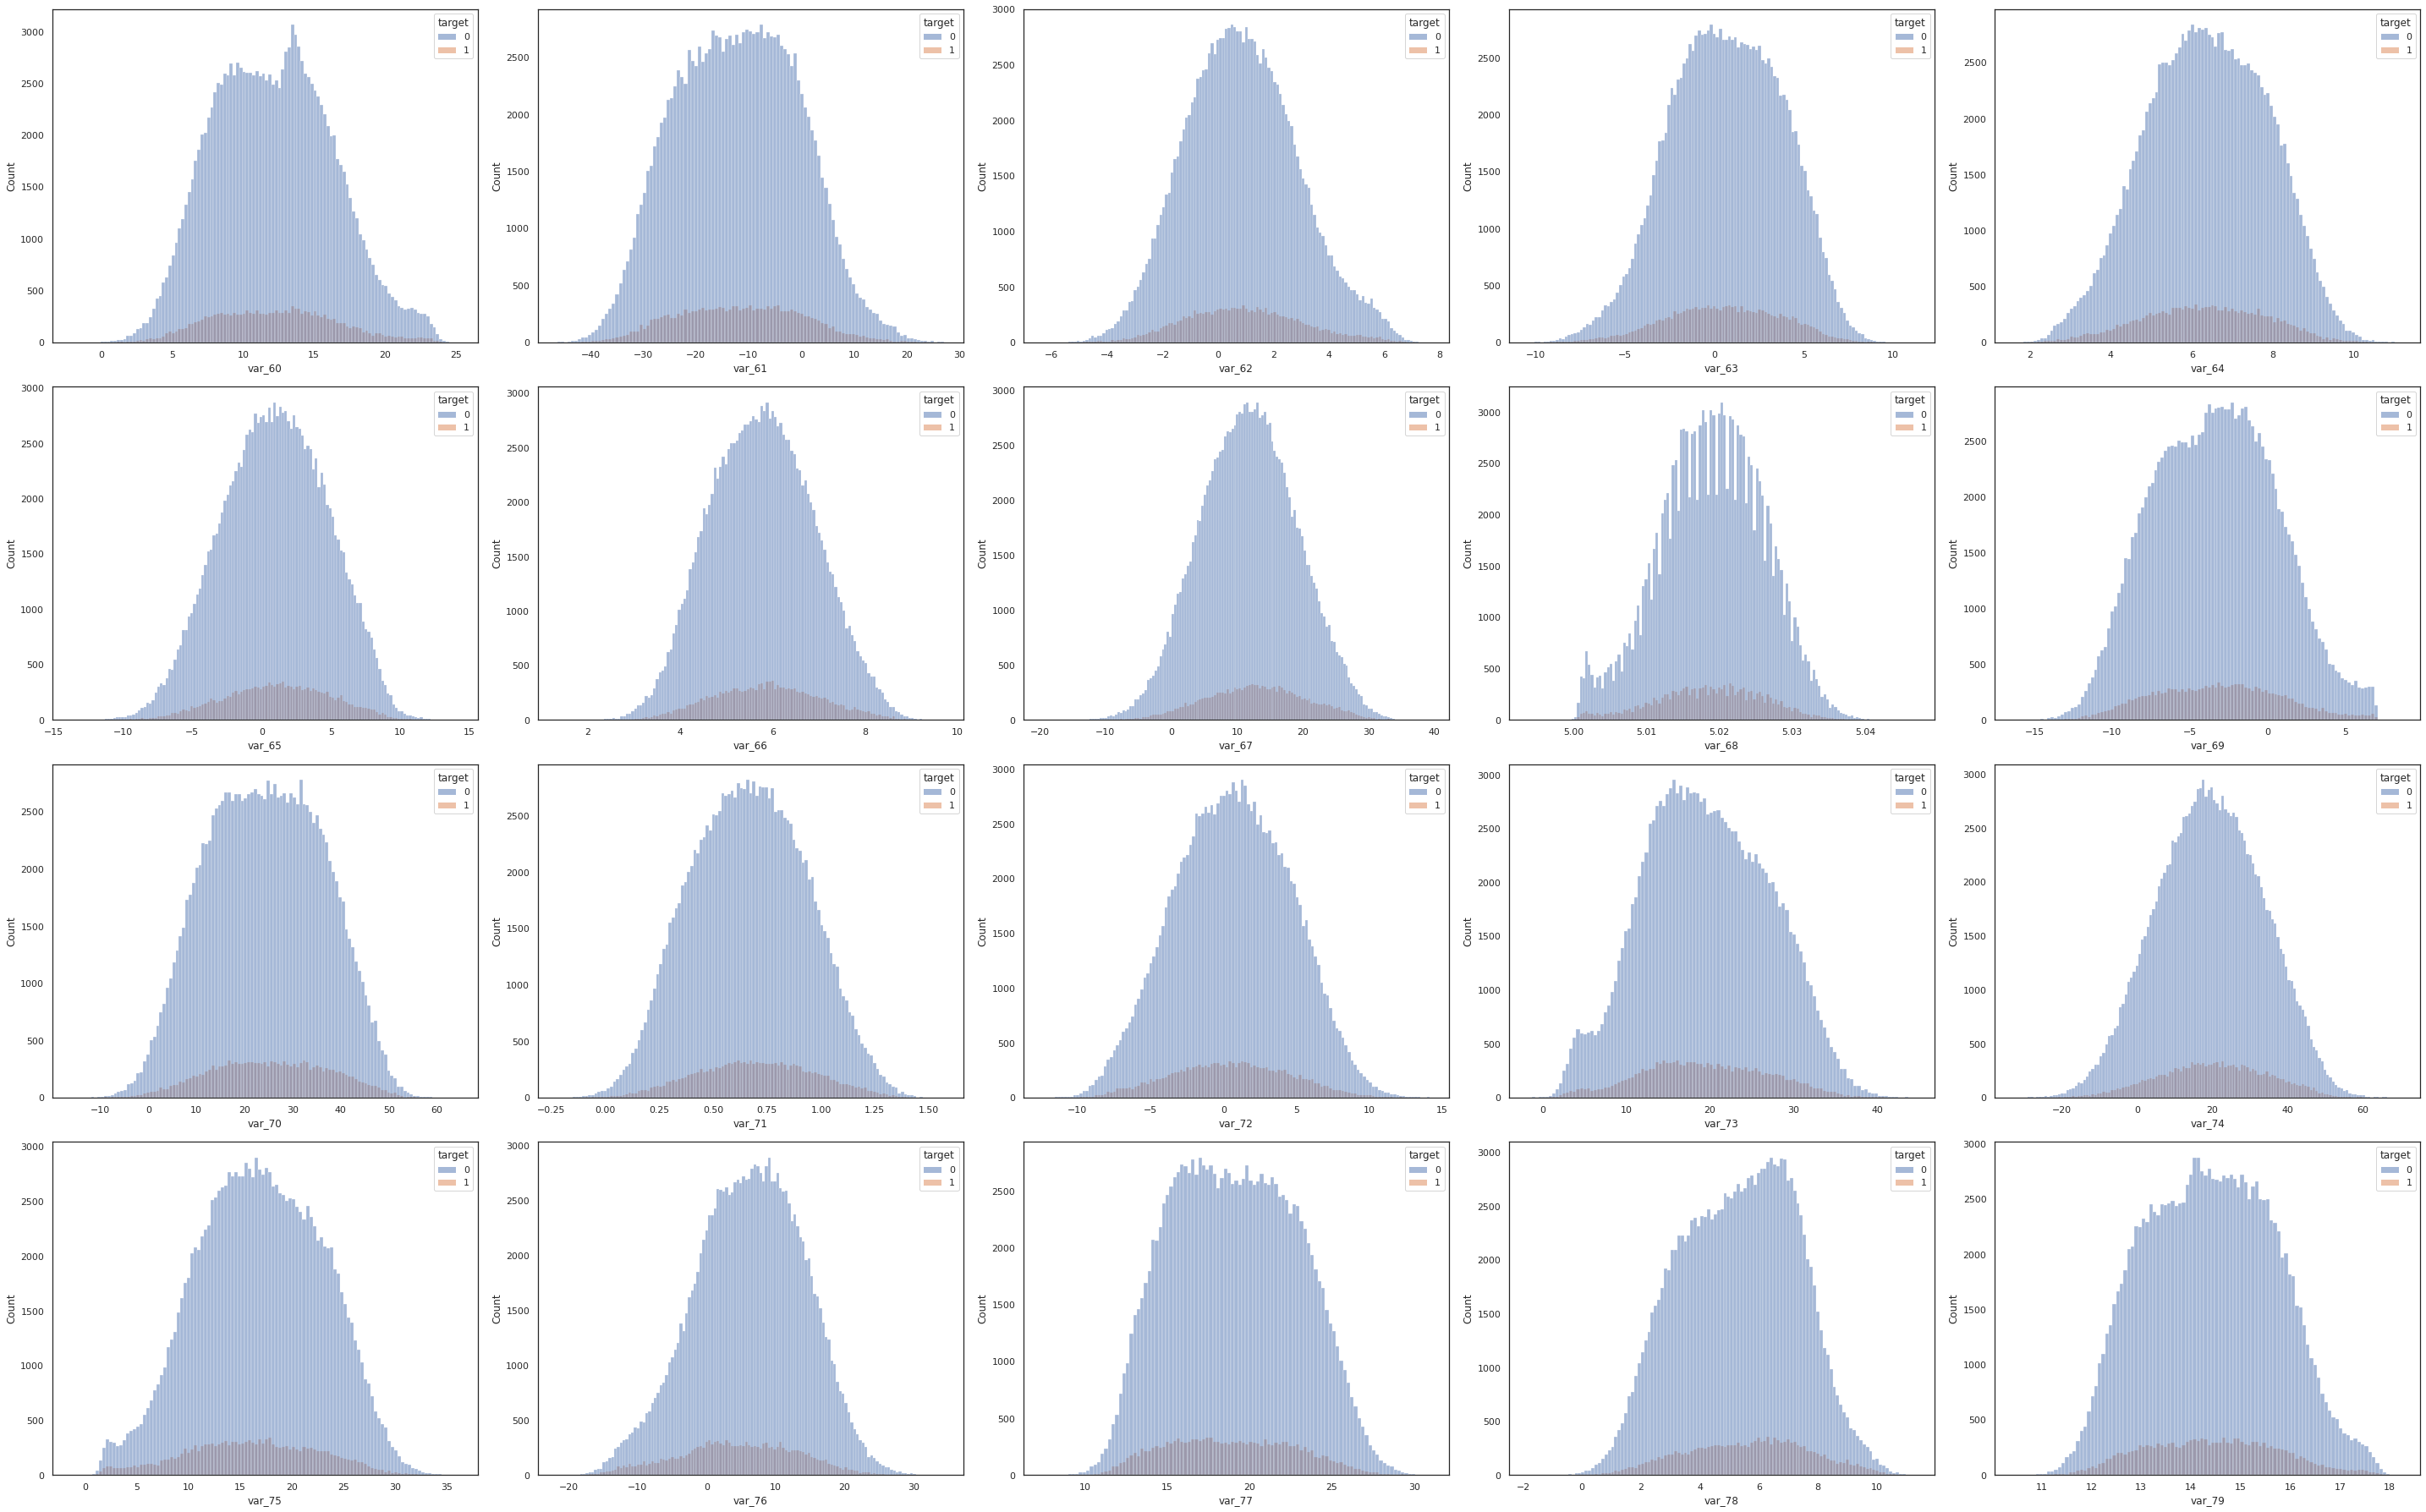

In [ ]:
plt.subplots(figsize=(40, 25))
sns.set(font_scale = 1, style = 'white')

for i, column in enumerate(train.iloc[:,62:82], 1):
    plt.subplot(4,5,i)
    sns.histplot(data=train, x=train[column], hue="target")
    
plt.tight_layout()

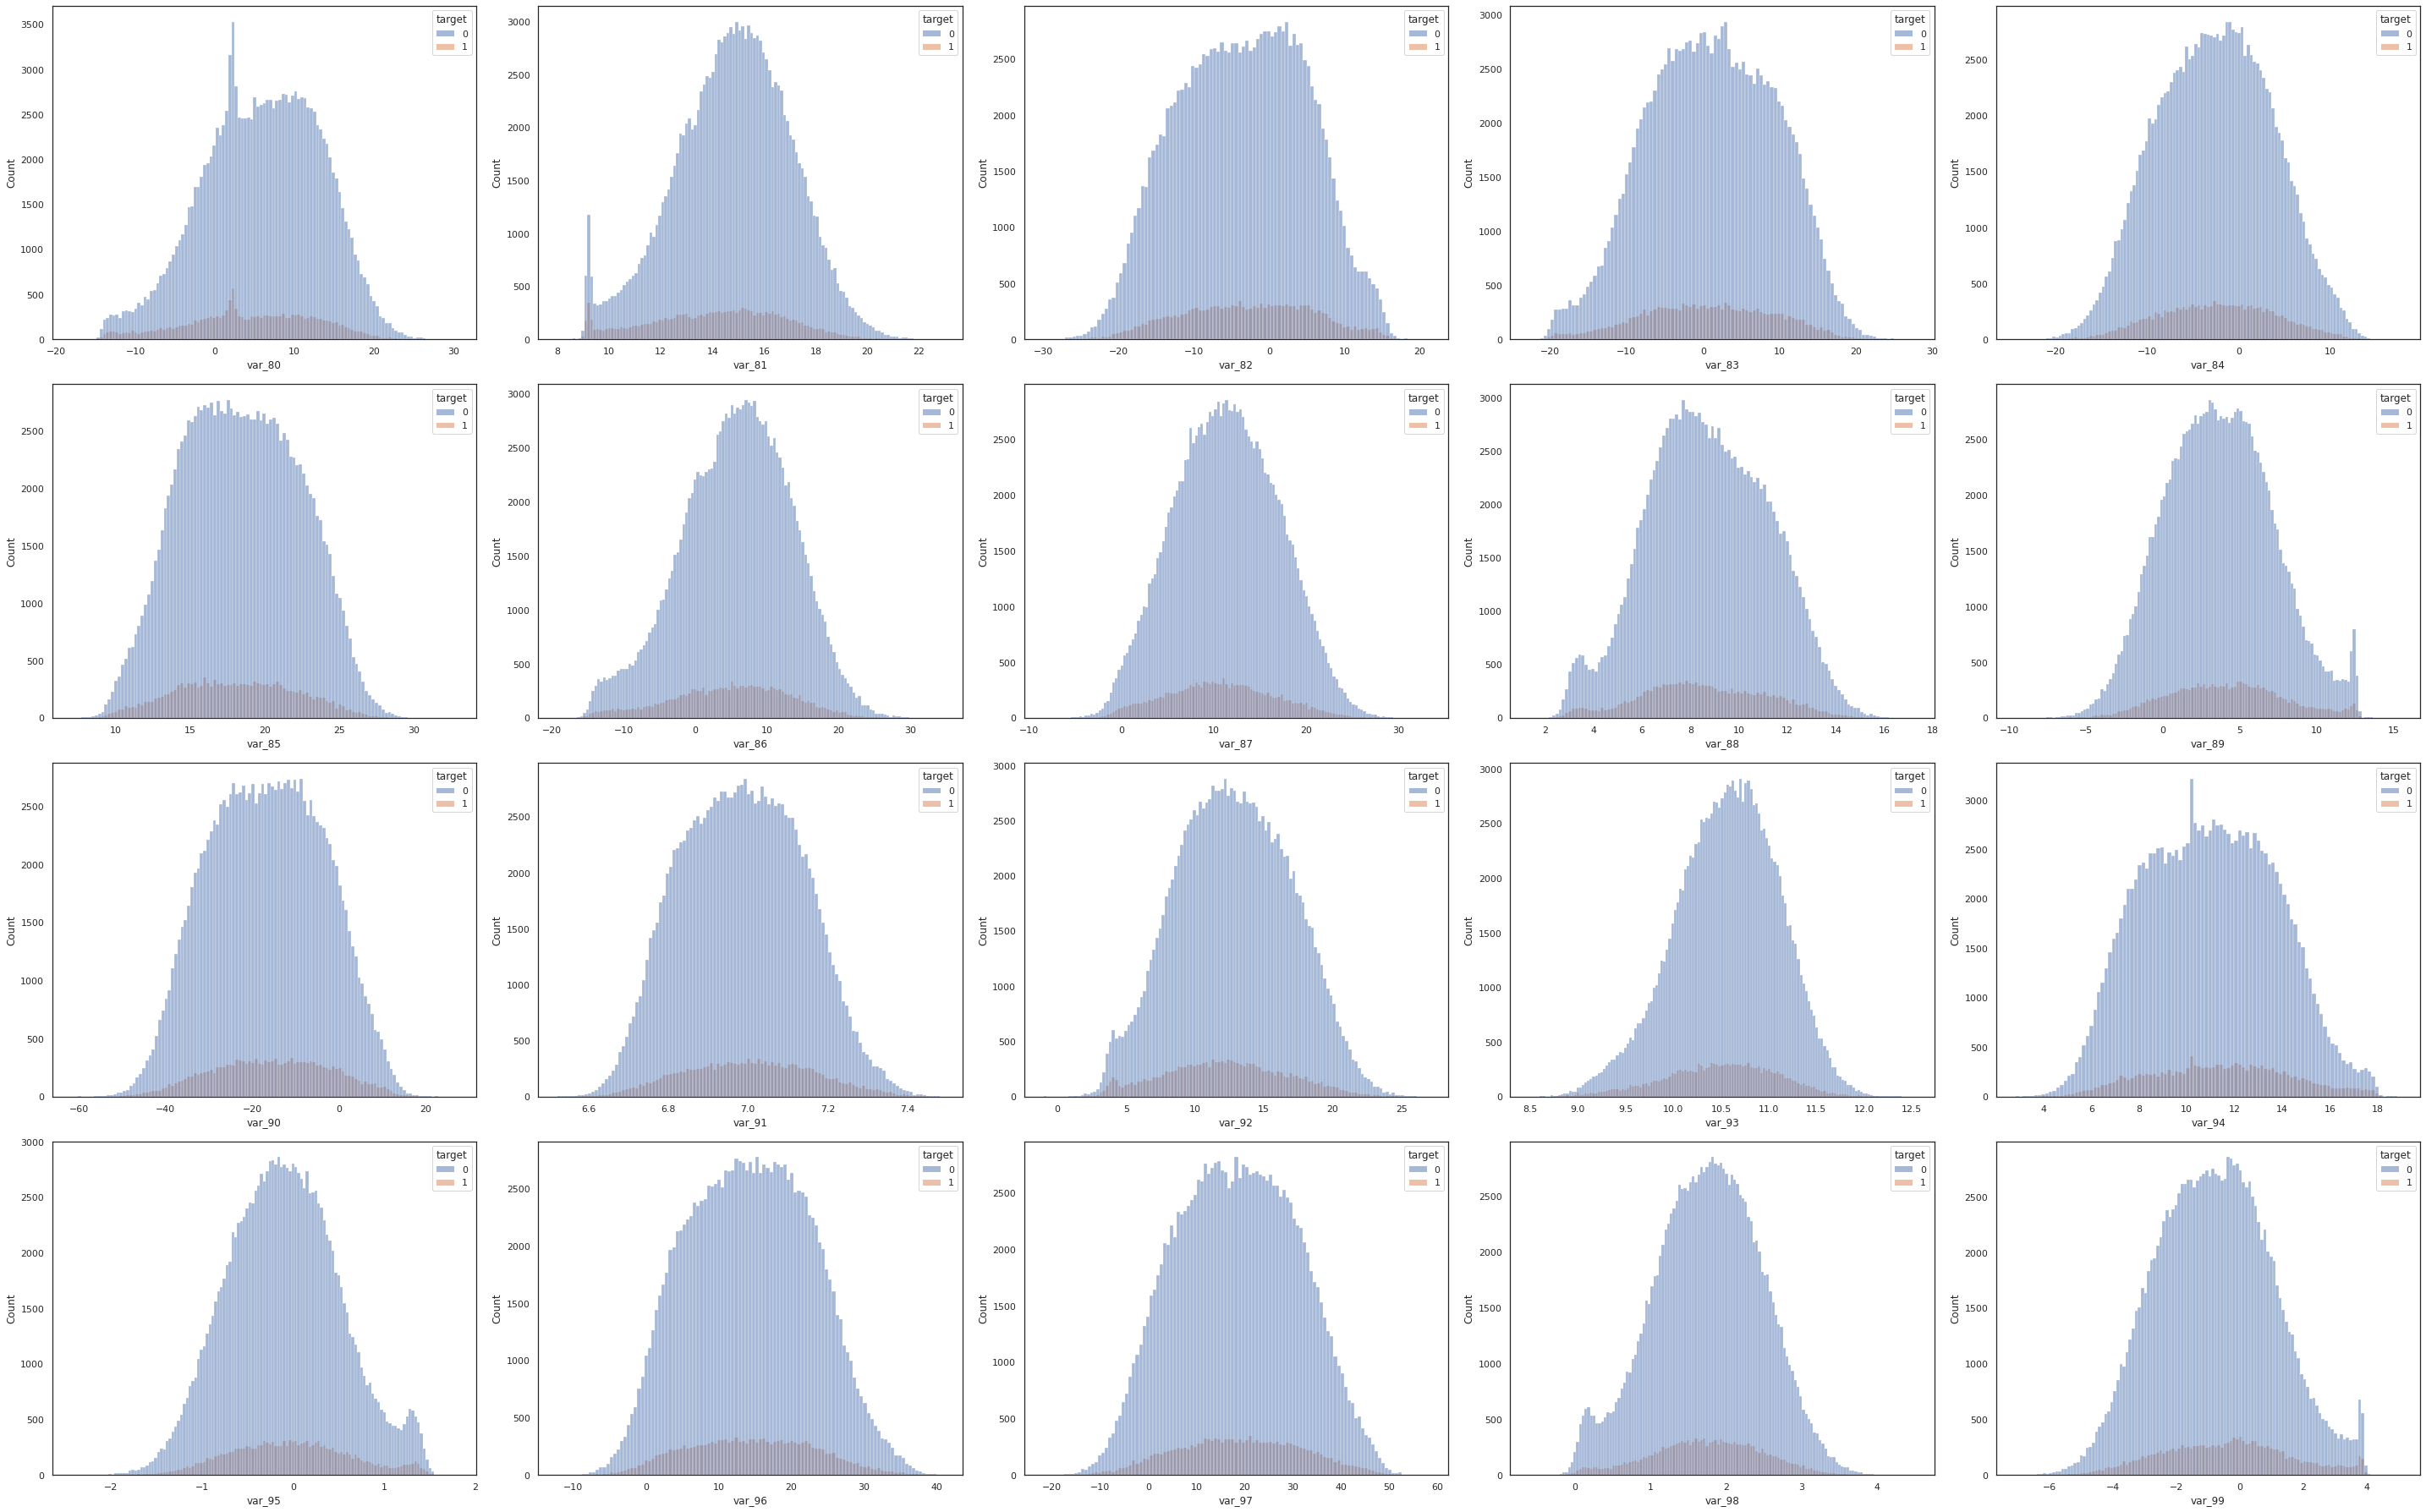

In [ ]:
plt.subplots(figsize=(40, 25))
sns.set(font_scale = 1, style = 'white')

for i, column in enumerate(train.iloc[:,82:102], 1):
    plt.subplot(4,5,i)
    sns.histplot(data=train, x=train[column], hue="target")
    
plt.tight_layout()

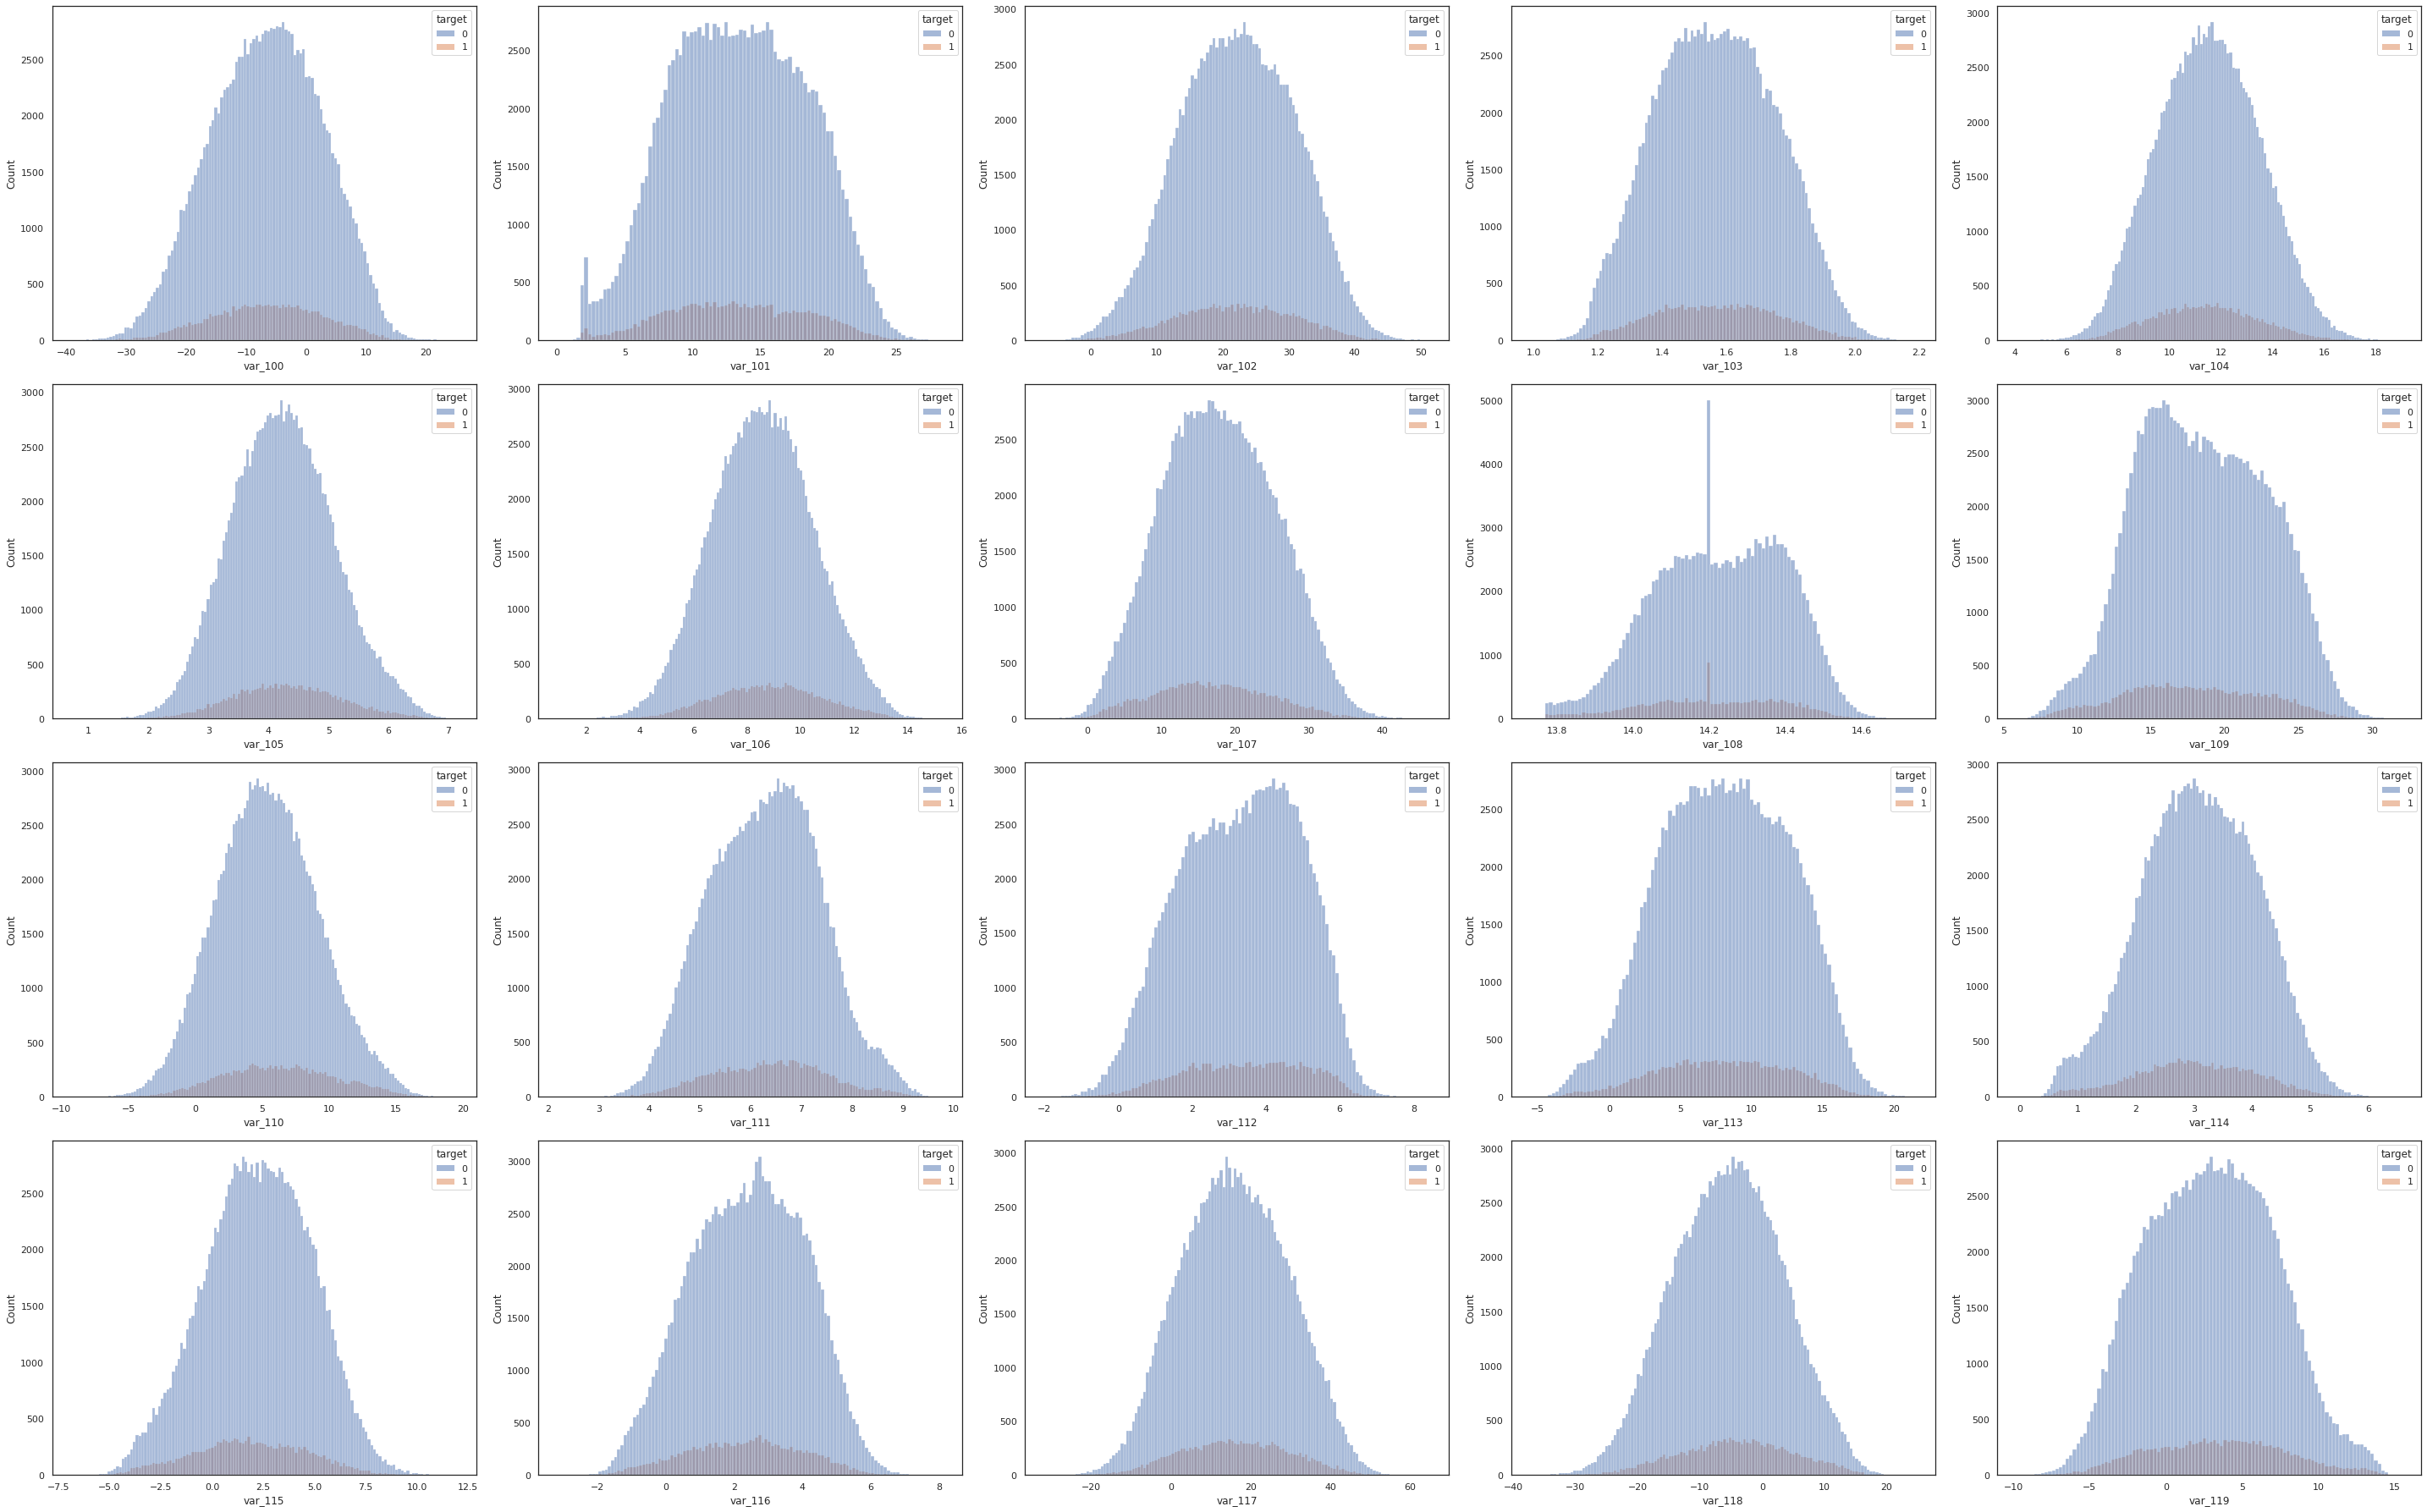

In [ ]:
plt.subplots(figsize=(40, 25))
sns.set(font_scale = 1, style = 'white')

for i, column in enumerate(train.iloc[:,102:122], 1):
    plt.subplot(4,5,i)
    sns.histplot(data=train, x=train[column], hue="target")
    
plt.tight_layout()

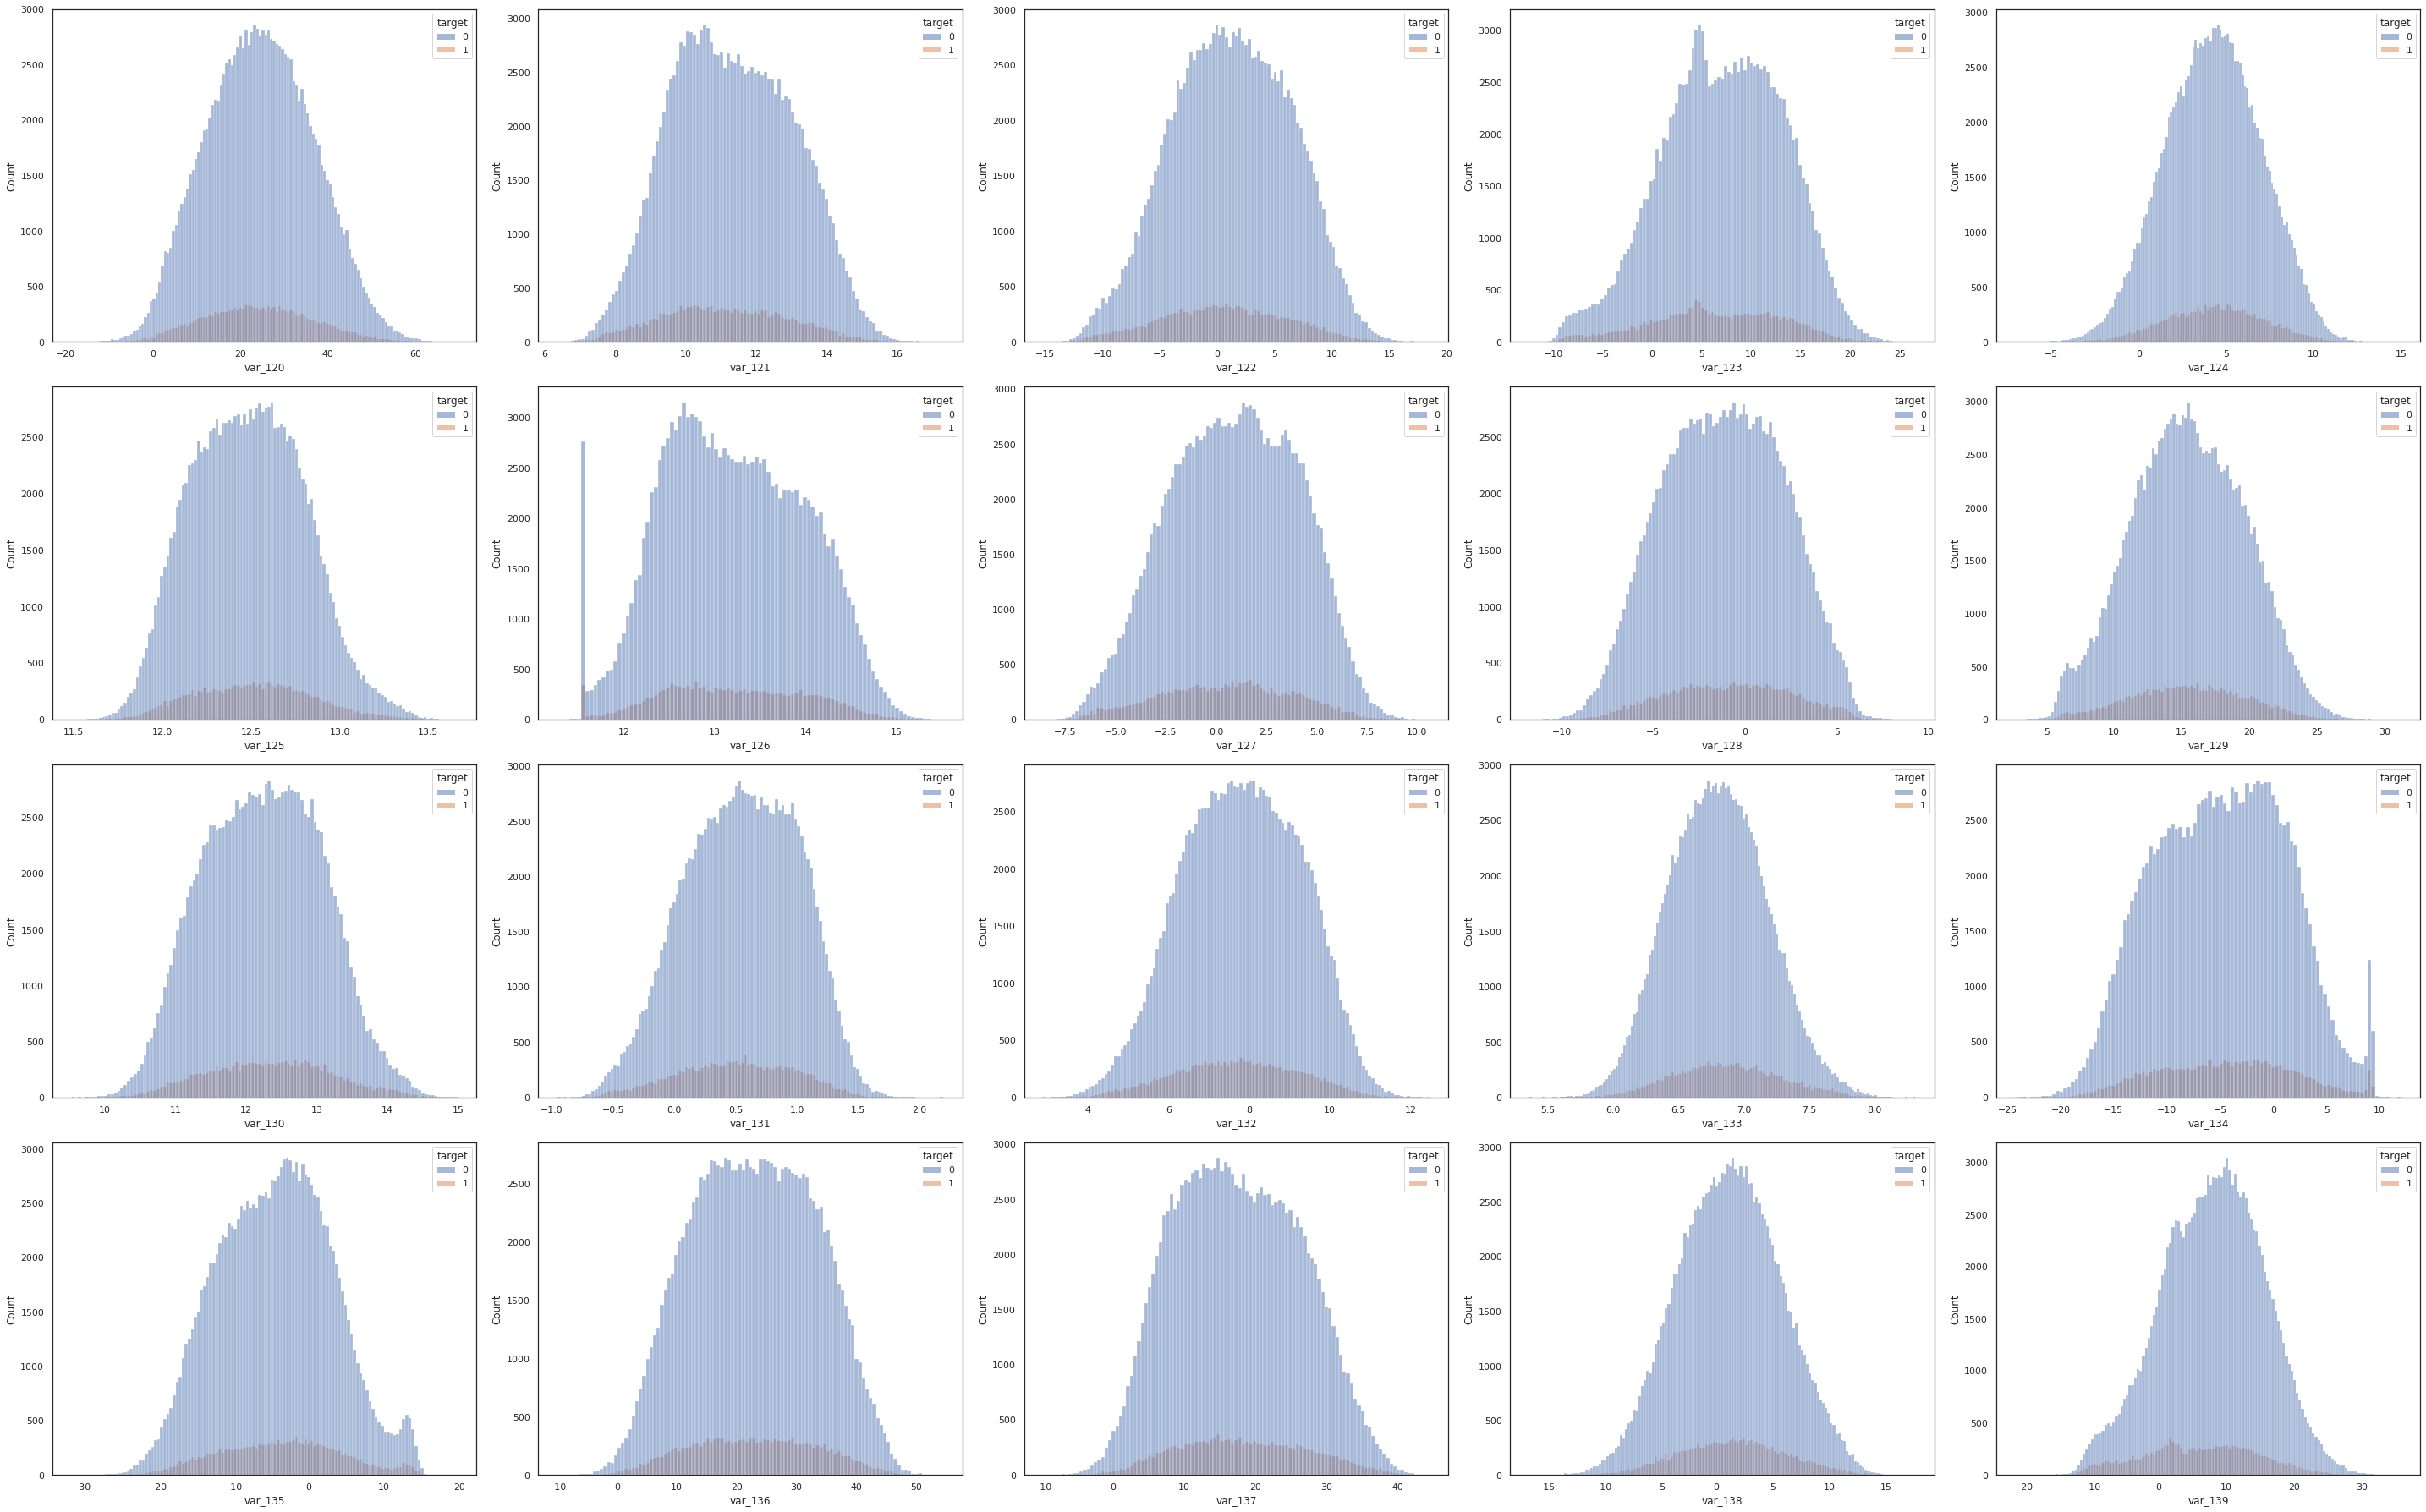

In [ ]:
plt.subplots(figsize=(40, 25))
sns.set(font_scale = 1, style = 'white')

for i, column in enumerate(train.iloc[:,122:142], 1):
    plt.subplot(4,5,i)
    sns.histplot(data=train, x=train[column], hue="target")
    
plt.tight_layout()

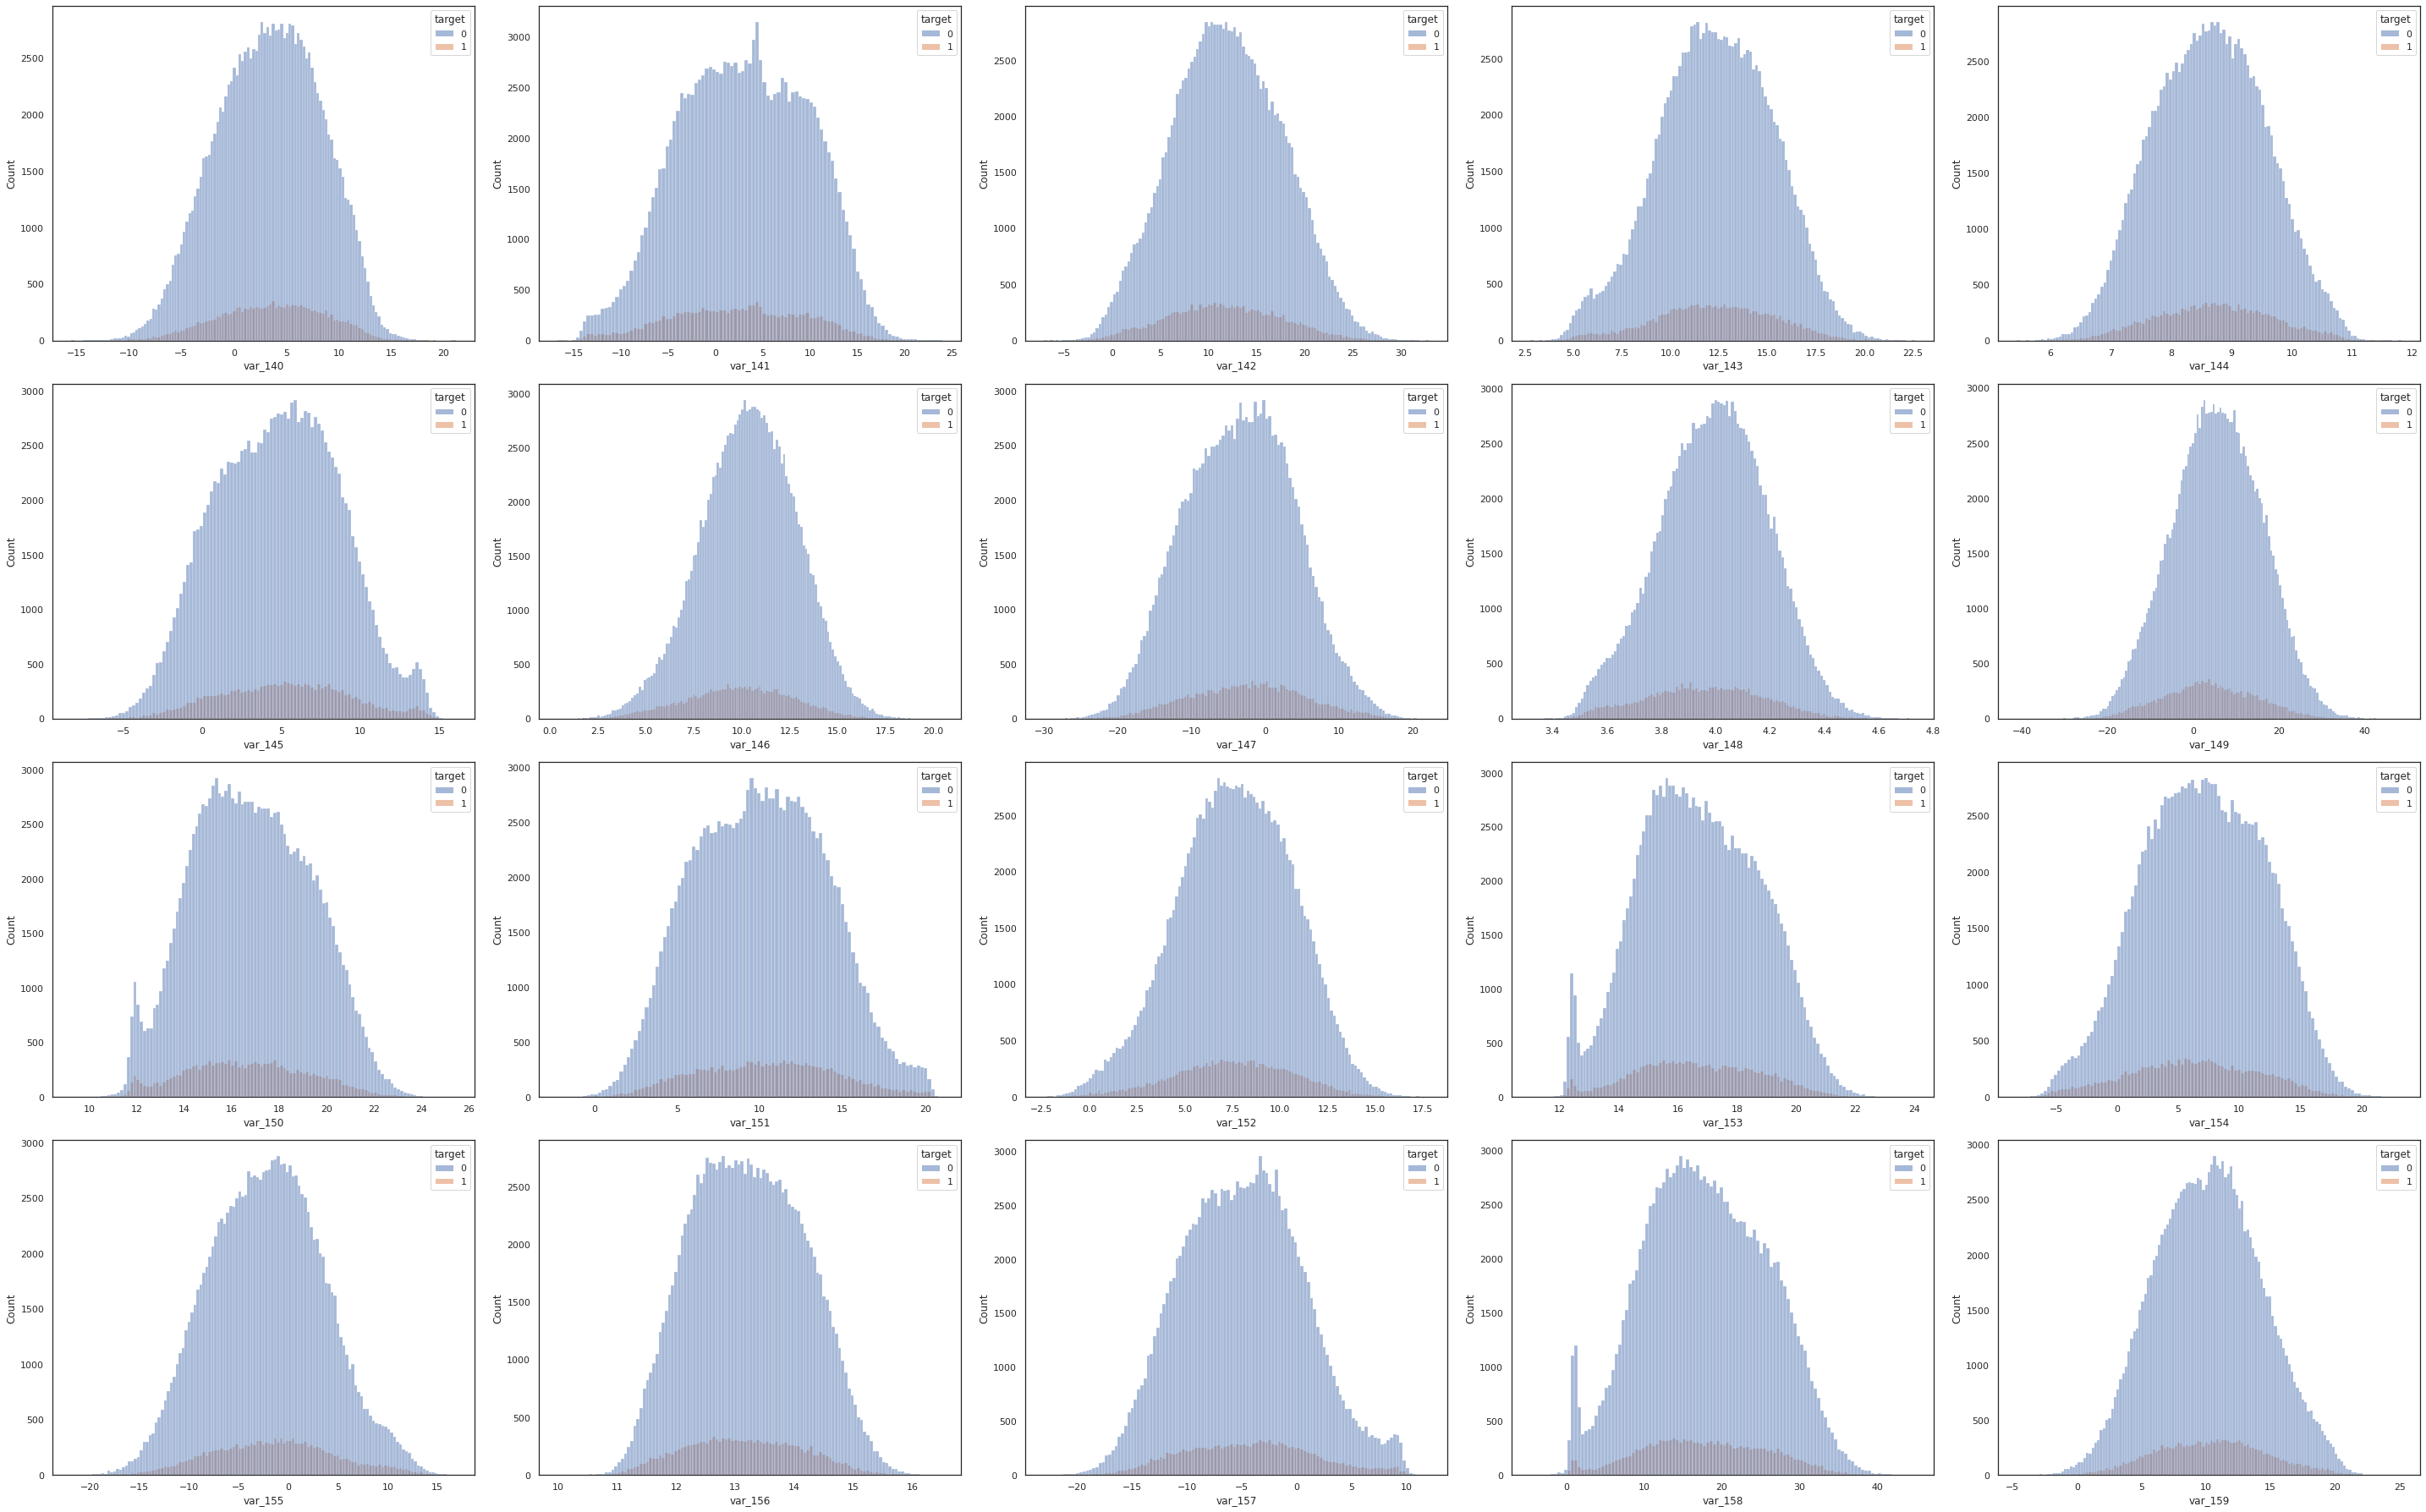

In [ ]:
plt.subplots(figsize=(40, 25))
sns.set(font_scale = 1, style = 'white')

for i, column in enumerate(train.iloc[:,142:162], 1):
    plt.subplot(4,5,i)
    sns.histplot(data=train, x=train[column], hue="target")
    
plt.tight_layout()

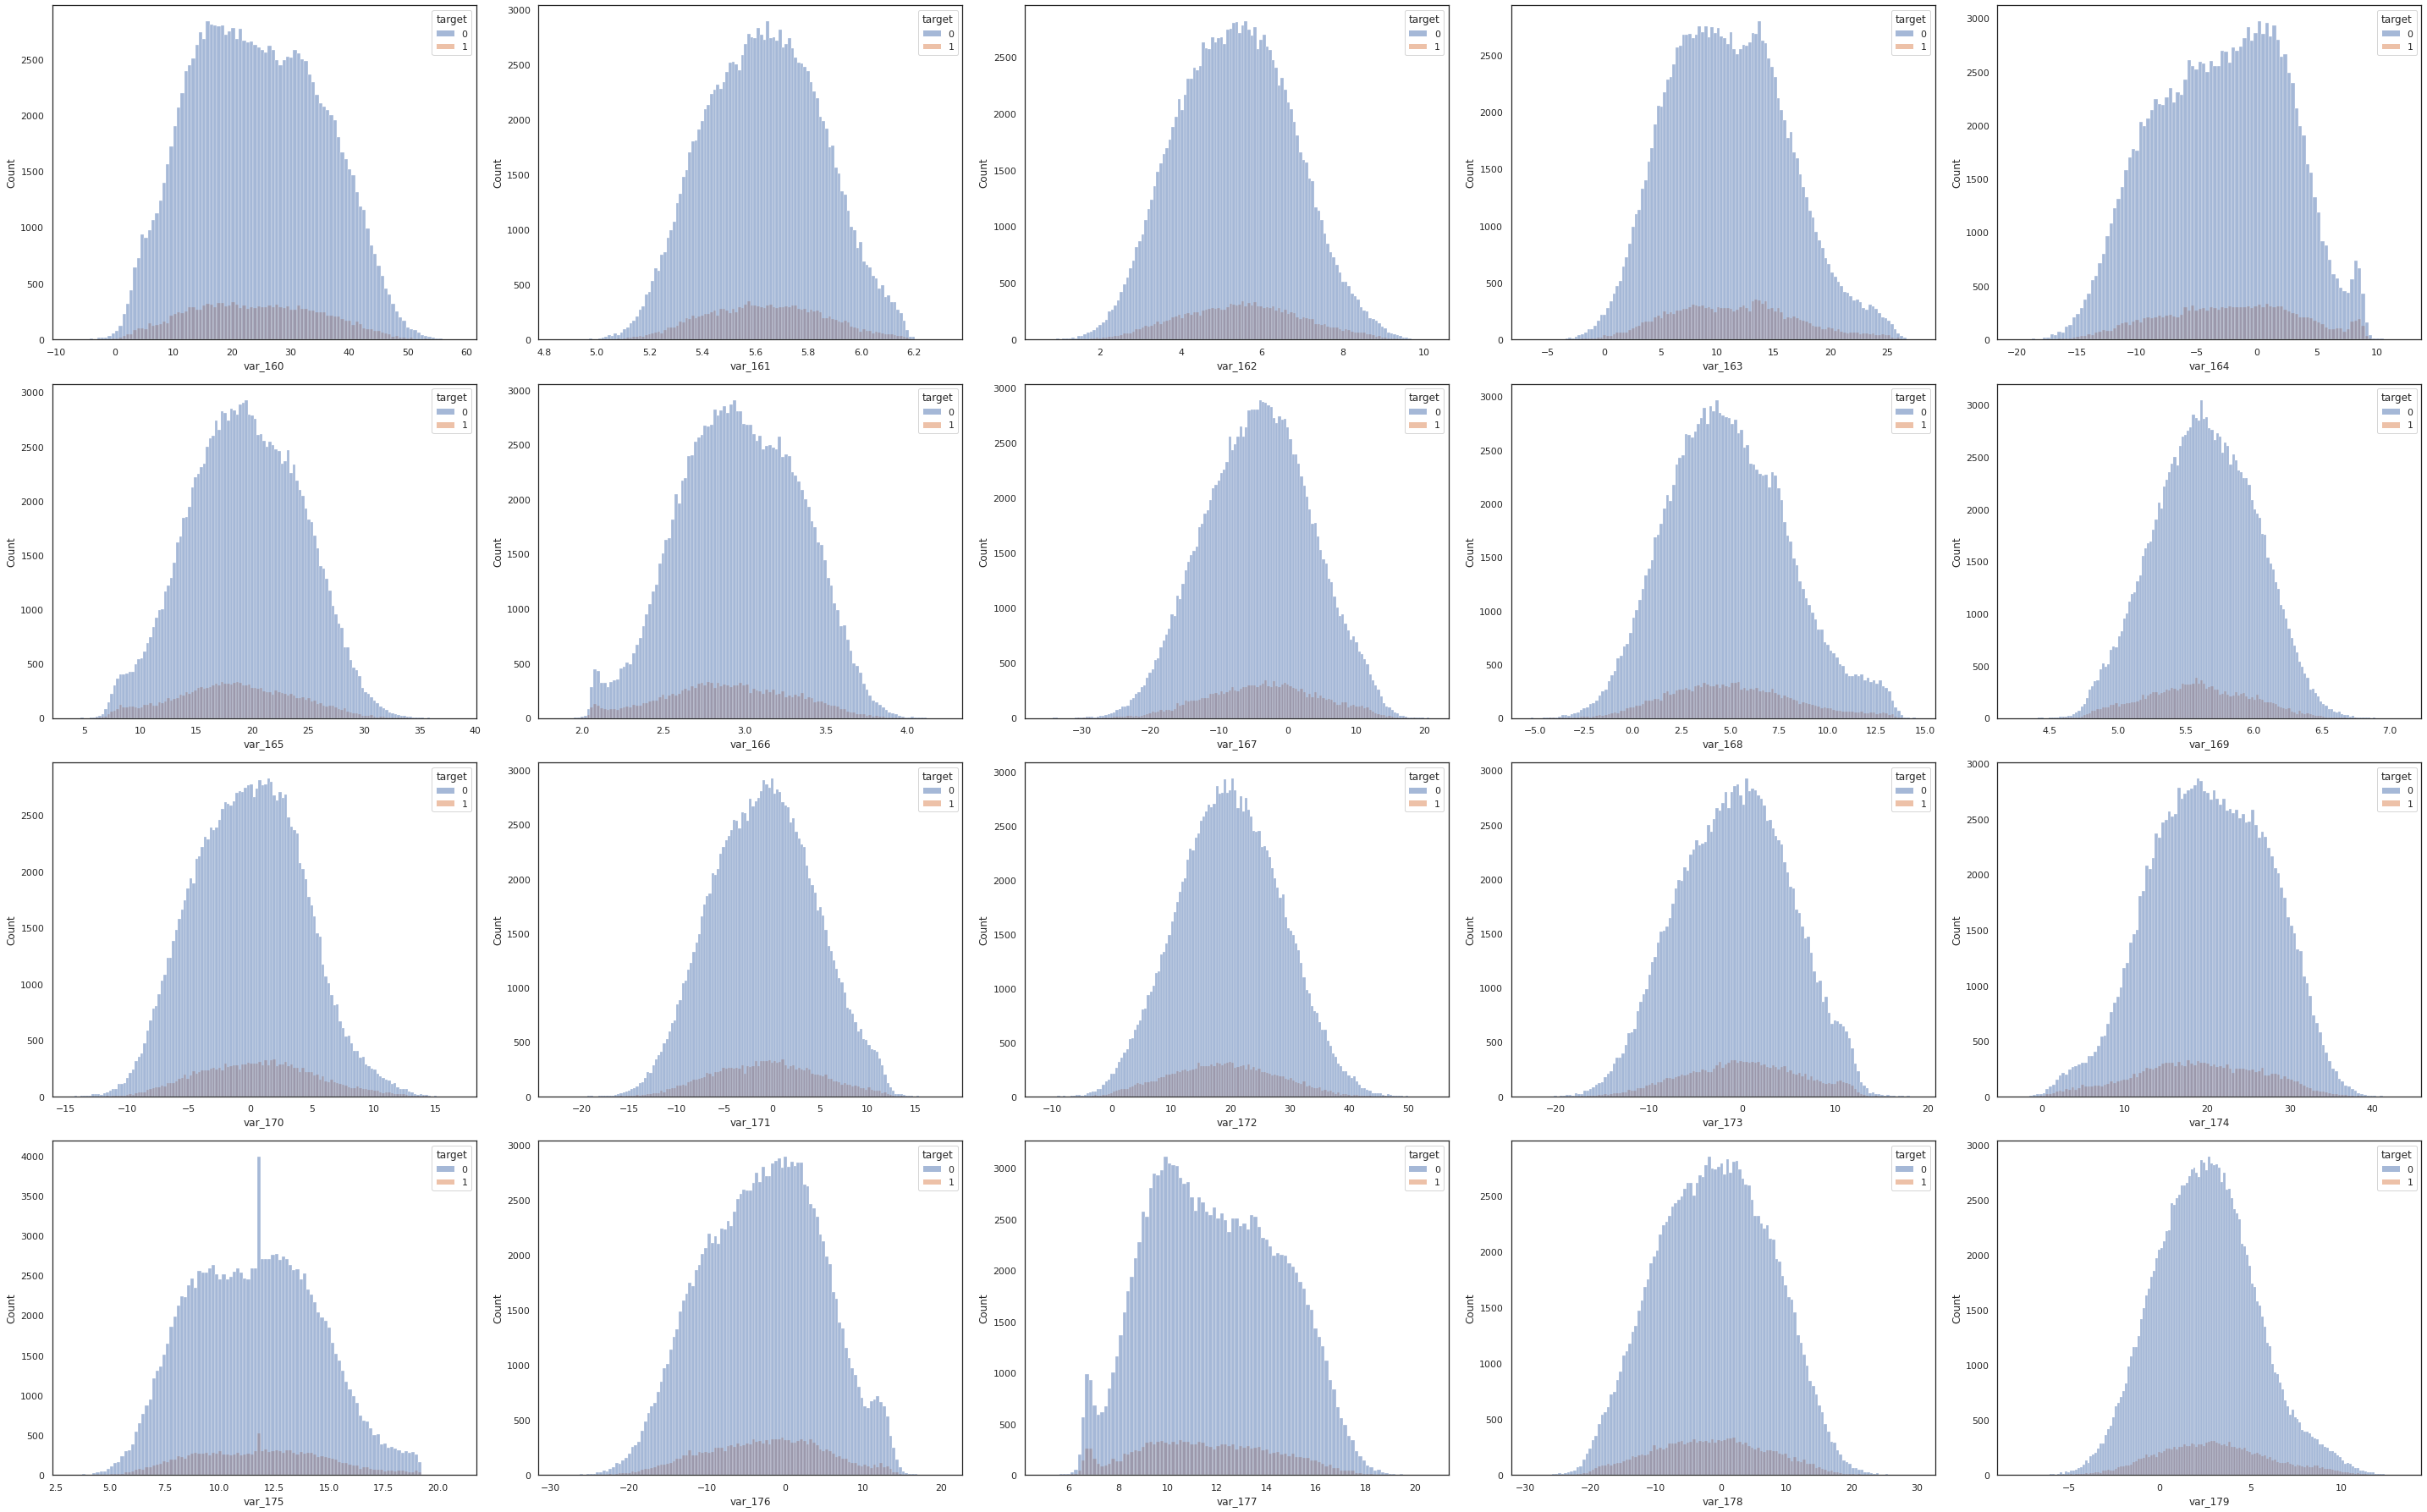

In [ ]:
plt.subplots(figsize=(40, 25))
sns.set(font_scale = 1, style = 'white')

for i, column in enumerate(train.iloc[:,162:182], 1):
    plt.subplot(4,5,i)
    sns.histplot(data=train, x=train[column], hue="target")
    
plt.tight_layout()

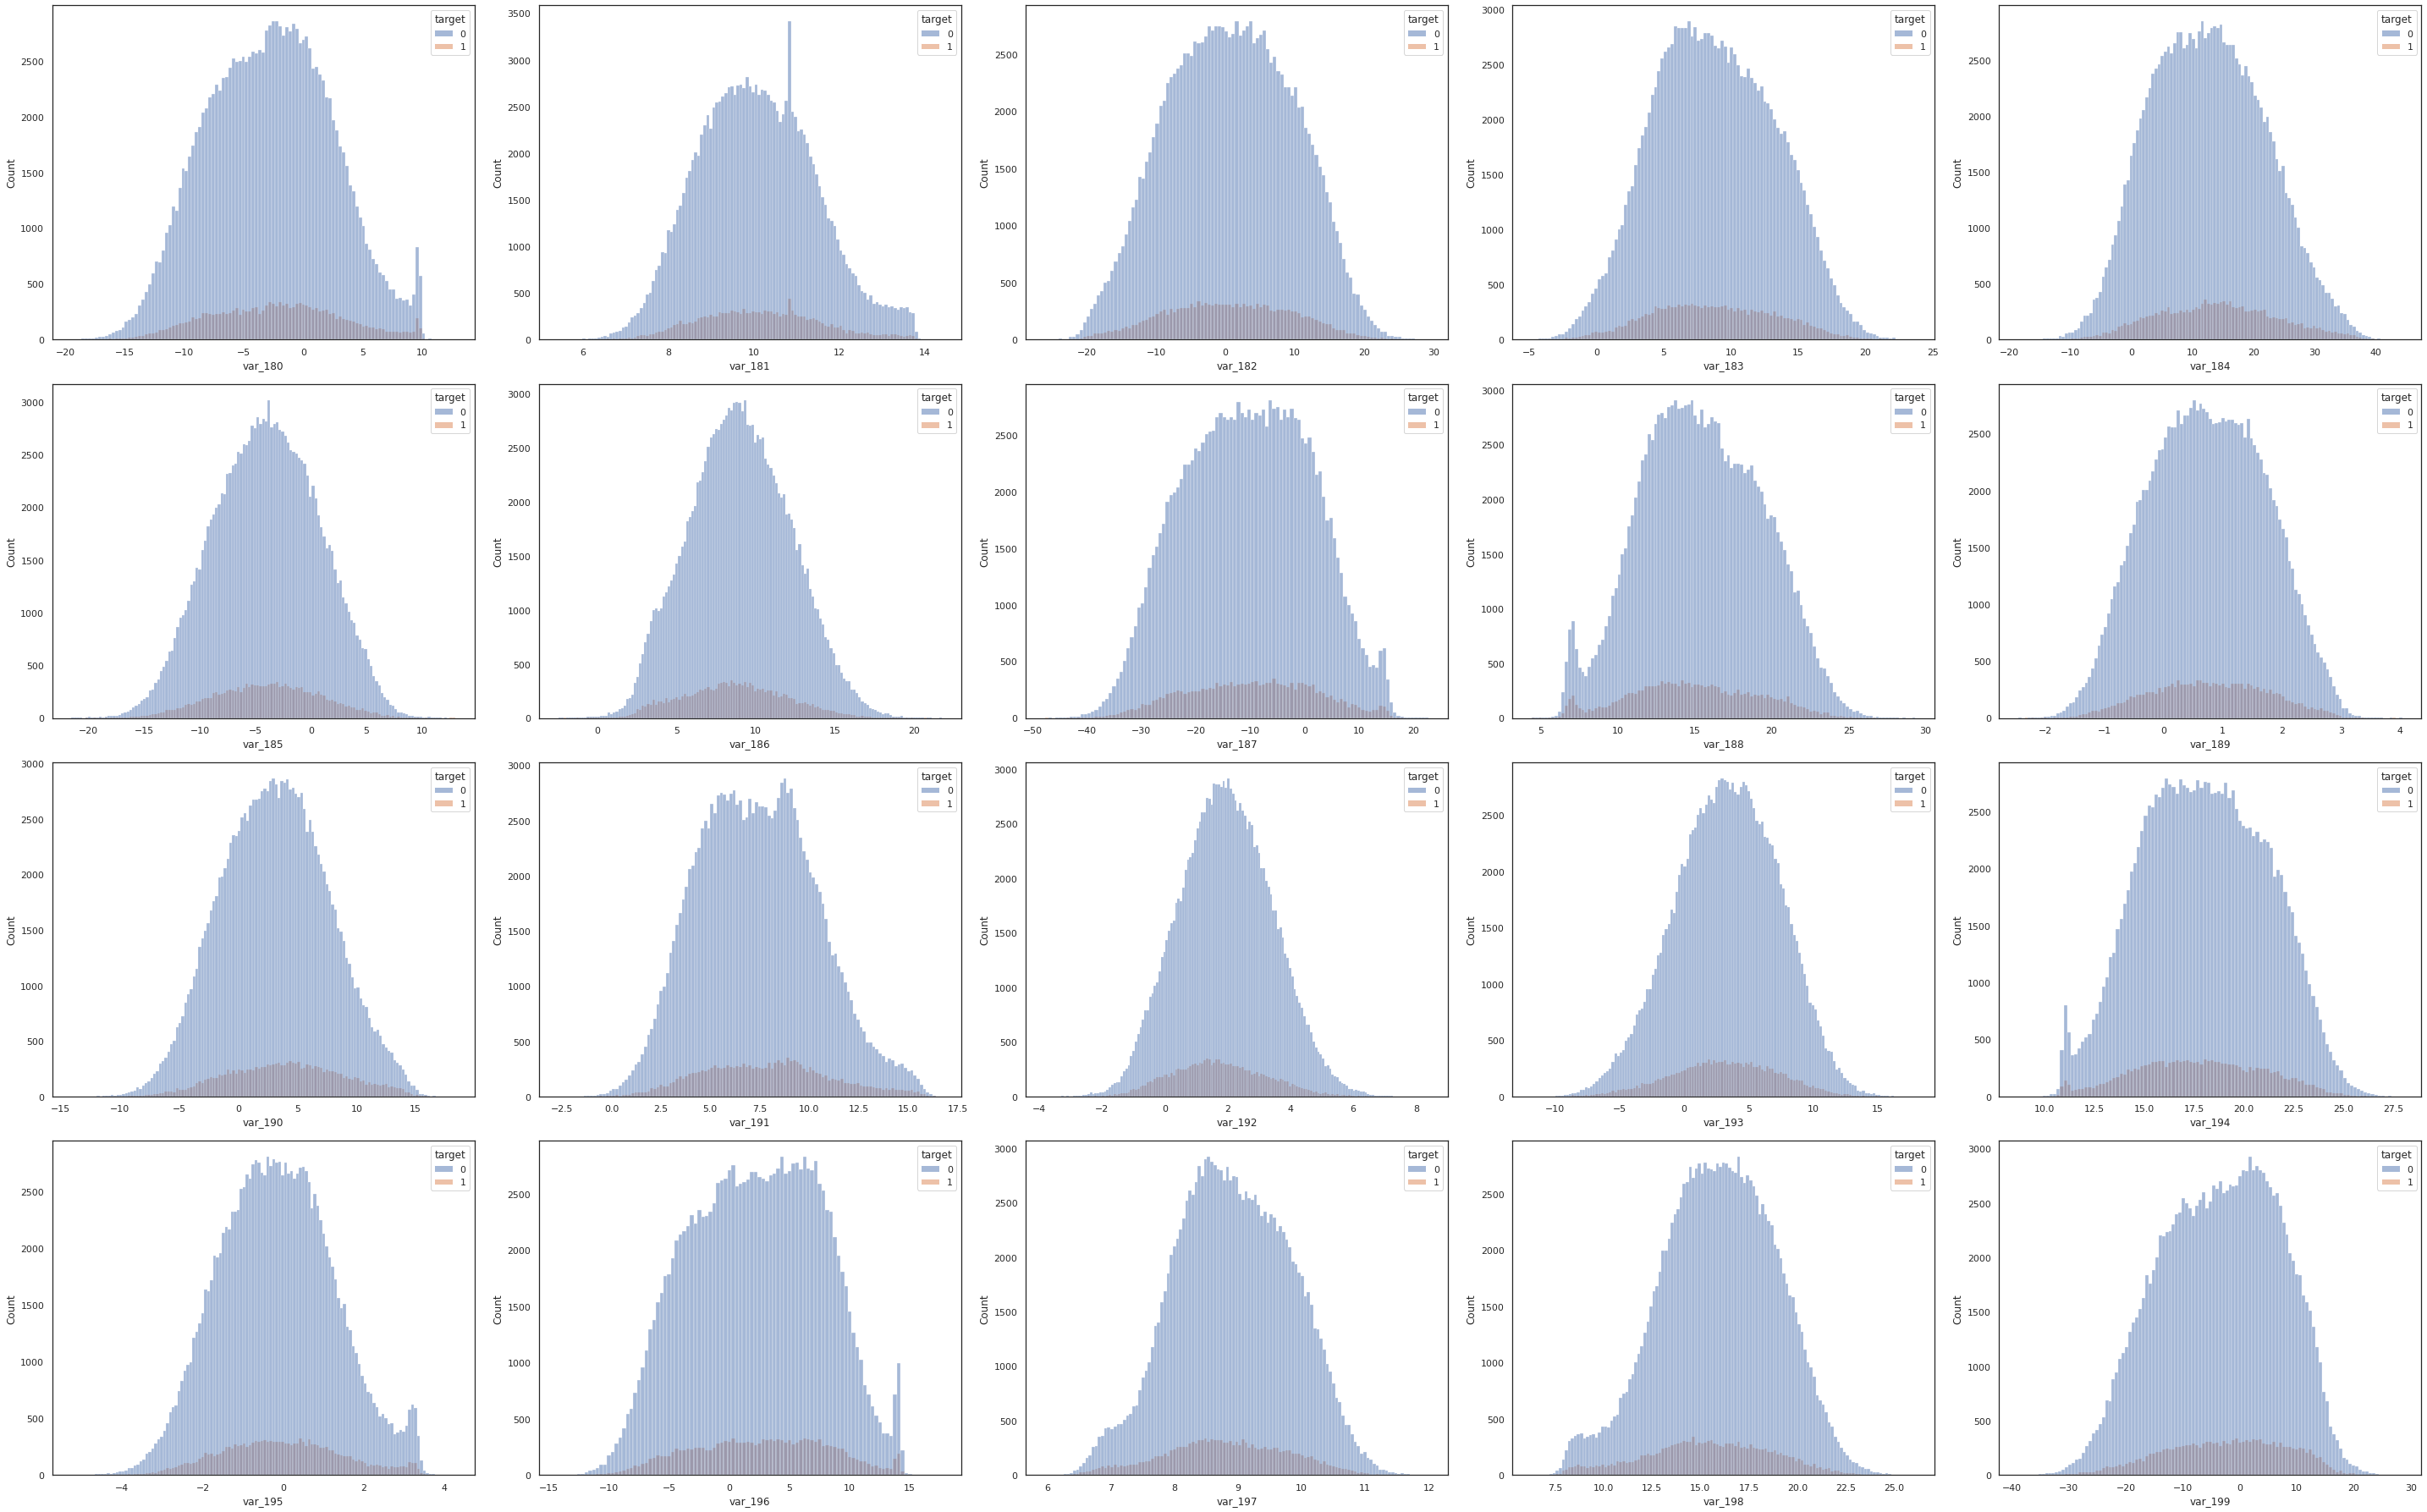

In [ ]:
plt.subplots(figsize=(40, 25))
sns.set(font_scale = 1, style = 'white')

for i, column in enumerate(train.iloc[:,182:], 1):
    plt.subplot(4,5,i)
    sns.histplot(data=train, x=train[column], hue="target")
    
plt.tight_layout()

## 상관관계

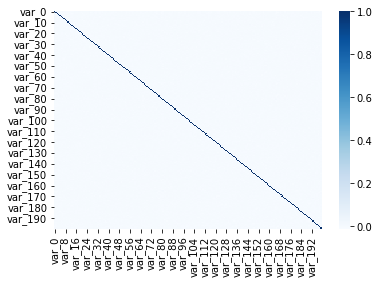

In [ ]:
sns.heatmap(cor, annot = False,
            cmap = "Blues")

In [17]:
cor = train.drop('target',axis = 1).corr()
cor

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
var_0,1.000000,-0.000559,0.007321,0.002932,0.001962,0.003295,0.008307,0.003977,0.004844,-0.003292,...,0.003146,-0.001350,-0.005660,0.001998,-0.001171,0.003069,0.002994,0.000280,-0.006417,0.004521
var_1,-0.000559,1.000000,0.002315,-0.000300,0.001666,-0.001972,0.003497,0.001942,0.003051,0.000679,...,0.006600,0.004654,-0.002037,0.003053,-0.003123,-0.001330,-0.001850,-0.004629,-0.004056,0.003498
var_2,0.007321,0.002315,1.000000,0.001378,-0.001255,0.000832,0.000942,-0.001758,0.003367,-0.002768,...,0.001346,0.002456,-0.005172,0.002999,0.001530,0.000184,0.002625,0.001264,-0.000963,0.002817
var_3,0.002932,-0.000300,0.001378,1.000000,-0.002620,0.002915,-0.000805,0.002178,0.003823,-0.000224,...,0.000626,0.001575,-0.000235,0.000043,-0.000829,-0.000342,0.000125,0.003196,-0.002391,0.000700
var_4,0.001962,0.001666,-0.001255,-0.002620,1.000000,-0.001618,-0.001574,0.004045,0.000595,-0.000621,...,0.001688,0.003669,0.001820,0.003004,0.000158,0.003250,0.001603,-0.000120,0.001018,0.000049
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
var_195,0.003069,-0.001330,0.000184,-0.000342,0.003250,-0.001976,0.002916,0.000777,0.001061,-0.001420,...,0.006556,0.000983,-0.004750,-0.001112,0.000633,1.000000,0.000898,-0.004906,-0.000632,0.002638
var_196,0.002994,-0.001850,0.002625,0.000125,0.001603,0.001158,0.003162,0.001140,-0.004568,0.002482,...,-0.000461,0.001765,-0.000254,-0.003138,-0.006041,0.000898,1.000000,-0.000740,-0.000459,-0.000816
var_197,0.000280,-0.004629,0.001264,0.003196,-0.000120,-0.001028,-0.002307,0.003232,-0.005545,0.003597,...,-0.006463,0.002144,-0.000512,0.003517,-0.001147,-0.004906,-0.000740,1.000000,0.000397,0.004093
var_198,-0.006417,-0.004056,-0.000963,-0.002391,0.001018,-0.000271,-0.002444,0.000370,0.001771,0.001856,...,-0.001974,0.000284,0.002150,0.000760,0.003176,-0.000632,-0.000459,0.000397,1.000000,-0.006485


### 동질성 검정(KS test)

동질성 검정 (target이 1, 0일때 분포가 비슷한 경우 존재 -> 동질성 검정 실시)

In [ ]:
train_pos=train[train['target']==1].iloc[:,2:]
train_neg=train[train['target']==0].iloc[:,2:]

In [ ]:
def homogeneity_TF(df1,df2):
    p=0
    result=pd.DataFrame()
    for i in df1.columns:
        if i in ['id','target']:
            pass
        elif re.search('_cat',i):
            ct1=pd.crosstab(df1['target'],df1[i])
            ct2=pd.crosstab(df2['target'],df2[i])
            ct=pd.concat([ct1,ct2])
            chi2, p, dof, expected = chi2_contingency(ct)
        elif re.search('_bin',i):
            ct1=pd.crosstab(df1['target'],df1[i])
            ct2=pd.crosstab(df2['target'],df2[i])
            ct=pd.concat([ct1,ct2])
            chi2, p, dof, expected = chi2_contingency(ct)
        elif train[i].nunique()>100: #고유하게 나타나는 값이 100 이상일때는 KS Test 진행
            p=kstest(df1[i],df2[i])[1]
        else: # 그 외에는 Ordinal Data라고 가정하고 카이제곱검정 진행
            ct1=pd.crosstab(df1['target'],df1[i])
            ct2=pd.crosstab(df2['target'],df2[i])
            ct=pd.concat([ct1,ct2])
            ct.fillna(0,inplace=True)
            chi2, p, dof, expected = chi2_contingency(ct)
            
        temp=pd.DataFrame.from_dict([{'Variable': i,'p_value':round(p,4)}])
        result=pd.concat([result,temp])
        
    return result

In [ ]:
hr=homogeneity_TF(train_pos,train_neg)
hr_list=hr[hr['p_value']<0.05].iloc[2:]['Variable'].to_list()
hr_list

['var_2',
 'var_3',
 'var_4',
 'var_5',
 'var_6',
 'var_8',
 'var_9',
 'var_11',
 'var_12',
 'var_13',
 'var_15',
 'var_16',
 'var_18',
 'var_19',
 'var_20',
 'var_21',
 'var_22',
 'var_23',
 'var_24',
 'var_25',
 'var_26',
 'var_28',
 'var_31',
 'var_32',
 'var_33',
 'var_34',
 'var_35',
 'var_36',
 'var_37',
 'var_39',
 'var_40',
 'var_42',
 'var_43',
 'var_44',
 'var_45',
 'var_47',
 'var_48',
 'var_49',
 'var_50',
 'var_51',
 'var_52',
 'var_53',
 'var_54',
 'var_55',
 'var_56',
 'var_57',
 'var_58',
 'var_59',
 'var_60',
 'var_62',
 'var_63',
 'var_64',
 'var_65',
 'var_66',
 'var_67',
 'var_68',
 'var_69',
 'var_70',
 'var_71',
 'var_72',
 'var_73',
 'var_74',
 'var_75',
 'var_76',
 'var_77',
 'var_78',
 'var_80',
 'var_81',
 'var_82',
 'var_83',
 'var_84',
 'var_85',
 'var_86',
 'var_87',
 'var_88',
 'var_89',
 'var_90',
 'var_91',
 'var_92',
 'var_93',
 'var_94',
 'var_95',
 'var_97',
 'var_98',
 'var_99',
 'var_101',
 'var_102',
 'var_104',
 'var_105',
 'var_106',
 'var_107',


In [ ]:
ho_list=hr[hr['p_value']>=0.05].iloc[2:]['Variable'].to_list()
ho_list

['var_14',
 'var_17',
 'var_27',
 'var_29',
 'var_30',
 'var_38',
 'var_41',
 'var_46',
 'var_61',
 'var_79',
 'var_96',
 'var_100',
 'var_103',
 'var_117',
 'var_126',
 'var_129',
 'var_136',
 'var_158',
 'var_160',
 'var_161',
 'var_183',
 'var_185']

In [ ]:
hr["p_value"]

0    0.0000
0    0.0000
0    0.0000
0    0.0017
0    0.0007
      ...  
0    0.0000
0    0.0000
0    0.0000
0    0.0000
0    0.0000
Name: p_value, Length: 200, dtype: float64

##  ACF Plot

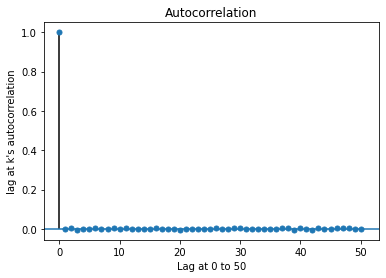

In [ ]:
def acf_plot(data, N_LAGS, alpha):
    from statsmodels.graphics.tsaplots import plot_acf
    
    fig = plot_acf(data, lags=N_LAGS, alpha=alpha)
    plt.xlabel(f'Lag at 0 to {N_LAGS}')
    plt.ylabel("lag at k's autocorrelation")
    plt.show()
  

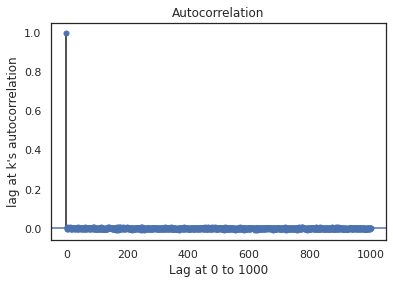

In [ ]:
acf_plot(x.iloc[:,3:4], 1000, 0.05)

In [ ]:
plt.subplots(figsize=(40, 45))
sns.set(font_scale = 1, style = 'white')

for i, val in enumerate(x.columns):
    plt.subplot(40,5,i+1)
    acf_plot(x[val], 50, 0.05)
    
plt.tight_layout()

Output hidden; open in https://colab.research.google.com to view.

## PACF Plot

In [ ]:
def pacf(data, alpha, N_LAGS):
    from statsmodels.tsa.stattools import pacf

    result = pd.DataFrame()

    result['pacf'] = pacf(data, alpha=alpha)[0][:N_LAGS+1]
    result['upper confidence interval'] = [pacf(data, alpha=alpha)[1][i][1] for i in range(N_LAGS + 1)]
    result['lower confidence interval'] = [pacf(data, alpha=alpha)[1][i][0] for i in range(N_LAGS + 1)]

    return result

In [ ]:
pacf_1 = pacf(x['var_1'], 0.05, 30)

In [ ]:
pacf_1.pacf

0     1.000000
1     0.000532
2    -0.001418
3     0.000262
4    -0.001002
5     0.000310
6    -0.002793
7     0.001853
8     0.001305
9     0.000759
10   -0.000692
11   -0.003404
12    0.000420
13    0.000353
14   -0.004631
15   -0.002180
16    0.003087
17    0.000185
18   -0.002390
19    0.001546
20    0.003360
21    0.002245
22    0.006163
23   -0.003512
24   -0.001604
25   -0.002552
26   -0.001966
27   -0.000216
28    0.002483
29    0.000903
30    0.000157
Name: pacf, dtype: float64

In [ ]:
def pacf_plot(data, N_LAGS, pval):
    from statsmodels.graphics.tsaplots import plot_pacf
    
    plot_pacf(data, lags=N_LAGS, alpha=pval, method='ywm')
    plt.xlabel(f'Lag at k (0 to {N_LAGS})')
    plt.ylabel("lag at k's Partial autocorrelation")
    plt.show()


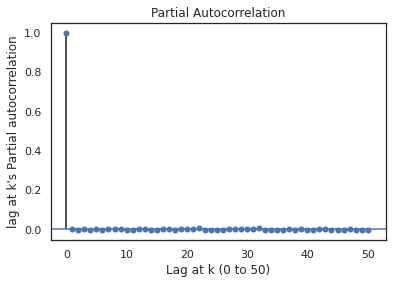

In [ ]:
pacf_plot(x['var_1'], 50, 0.05)

자기상관 특별히 존재 x

In [7]:
X = train.iloc[:,2:]
y = train.iloc[:,1:2]

In [8]:
seedBasic(42)

test1=test.copy()
test1=test1.drop(["ID_code"],axis=1)

### GMM clusetring 최적군집 개수 설정(오래걸림)

In [22]:
seedBasic(42)

components = np.arange(start_components, max_components, 1)
kf = StratifiedKFold(n_splits=n_splits)
    
scores = np.zeros(shape=(max_components-start_components, n_splits))

for m in components:
    split=0
    print("Components " + str(m))
    for train_index, test_index in kf.split(X, y):
        print("Split " + str(split))
        x_train, x_test = X.loc[train_index], X.loc[test_index]
        gm = GaussianMixture(n_components=m, random_state=seeds[m-start_components])
        gm.fit(x_train)
        score = gm.score(x_test)
        scores[m-start_components,split] = score
        split +=1
    
print(np.round(np.mean(scores, axis=1), 2))
print(np.round(np.std(scores, axis=1), 2))
best_idx = np.argmax(np.mean(scores, axis=1))
best_component = components[best_idx]
best_seed = seeds[best_idx]
print("Best component found " + str(best_component))

Components 3
Split 0
Split 1
Split 2
Components 4
Split 0
Split 1
Split 2
Components 5
Split 0
Split 1
Split 2
Components 6
Split 0
Split 1
Split 2
Components 7
Split 0
Split 1
Split 2
Components 8
Split 0
Split 1
Split 2
Components 9
Split 0
Split 1
Split 2
[-500.32 -500.47 -500.6  -500.74 -500.87 -500.98 -501.11]
[0.03 0.03 0.02 0.02 0.03 0.03 0.02]
Best component found 3


### 군집 파생변수 생성

In [14]:
seedBasic(42)

gmm = GaussianMixture(n_components=3, random_state=42)
gmm.fit(X)

X['gmm_cluster'] = gmm.predict(X)
test1["gmm_cluster"] = gmm.predict(test1)

In [15]:
new_train=X.copy()
new_train["target"] = y

In [16]:
new_train.to_csv("train2.csv", index=False)
test1.to_csv("test2.csv", index=False)